# W207 Final Project: Stock Price Prediction on the Jane Street Dataset

## Team Members

John Andrus  
Fernando Roriz  
Kevin Fu  
Luis Chion  

## Introduction

In February 2021, Jane Street Group sponsored a featured competition on Kaggle where individuals could train machine learning models on real-world financial data and compete to achieve the highest return in a stock-trading simulation. The data consisted of approximately 1.5 million instances of time-series market data expressed over 130 anonmyous features, a return, and a binary buy/sell label. In this project, our team uses the Jane Street dataset to create our own models in an attempt to maximize the accuracy of our predictions and the hypothetical return of our trades.  

In this report, we explore an initial sampling of machine learning models on subsections of the training data, evaluate those models on runtime and accuracy, and select from among them the three models with the highest performance and the most support within the academic literature. We then take a deeper dive into these three choices - CNN, GMM, and LSTM - in order to refine their hyperparameters and maximize their utility in solving this problem.  

Finally, we will compare all of the models in a horse race. We will draw conclusions from the three final models we selected, evaluating whether both their accuracy and their utility scores would create a profitable training model and which, if any, have the potential to be delivered to a real-world trading scenario. We will then identify areas for improvement, areas for future work, and lessons learned.

## Import Relevant Libraries and Packages

The cell below houses a listing of all of the libraries and packages that are used in this report, separated by purpose.

In [ ]:
# Import relevant libraries and packages

#Data Analysis
import numpy as np
import scipy
import pandas as pd

#Visualization
from matplotlib import pyplot as plt
import seaborn as sns

#Runtime Evaluation
import time

#Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

#Tools, Metrics, and Reports
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn import tree
from tabulate import tabulate

sns.set_style('whitegrid')
SEED = 2222
np.random.seed(SEED)

## Workflow


This Jupyter notebook was created in Google Colaboratory and trained on data stored in Google Drive. The cell below mounts our shared team Google Drive (*) into the Colab workspace, giving us access to the dataset.

In [ ]:
# Mount Google Drive to this location
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(*) To access the data, please request for permission and map the following google directory to your drive: https://drive.google.com/drive/u/0/folders/1UZEYGdU0aMV7WEwq7bM5cl1hDIKG_DDI

## Load and Organize Preprocessed Dataset


Reference final_project_data_preprocessing.ipynb to see in-depth exploration of the data and preprocessing activities that were used to generate the train_jain.npz data file.

In [ ]:
#Load the preprocessed dataset stored in .npz format
%%time 
train = np.load('drive/MyDrive/w207-6-spring2021-fintech/janestreet_dataset/train_jane.npz')
print(train.files)

['X_train', 'y_train', 'dates', 'weights', 'resps']
CPU times: user 0 ns, sys: 70 ms, total: 70 ms
Wall time: 69.8 ms


In the cells below, we separate the full dataset into separate Training, Dev, and Test datasets. Given that this is time series data, we did not use a Train-Test split. The data is in chronological order and we opted to preserve that order. We have also created a mini training dataset in order to speed up computation time in the earlier stages of our model exploration.

In [ ]:
# Organize data into feature variables and labels
X_train = train['X_train']
y_train = train['y_train']
dates=train['dates']
weights=train['weights'] 
resps=train['resps']

In [ ]:
# Set some variables to hold test, dev, and training data
test_data, test_labels, test_dates, test_weights, test_resps = X_train[80000:100000], y_train[80000:100000], dates[80000:100000], weights[80000:100000], resps[80000:100000]
dev_data, dev_labels, dev_dates, dev_weights, dev_resps = X_train[150000:200000], y_train[150000:200000], dates[150000:200000], weights[150000:200000], resps[150000:200000]
train_data, train_labels, train_dates, train_weights, train_resps = X_train[:70000], y_train[:70000], dates[:70000], weights[:70000], resps[:70000]
mini_train_data, mini_train_labels, mini_train_dates, mini_train_weights, mini_train_resps = X_train[:50000], y_train[:50000], dates[:50000], weights[:50000], resps[:50000]

# Previous iterations
#dev_data, dev_labels, dev_dates, dev_weights, dev_resps = X_train[50000:70000], y_train[50000:70000], dates[50000:70000], weights[50000:70000], resps[50000:70000]

In [ ]:
#Display shapes of Train, Dev, and Test Data
print('Shape of Full Dataset Features:',X_train.shape)
print('Shape of Full Dataset Labels:',y_train.shape)
print('Shape of Training Data Features:',train_data.shape)
print('Shape of Training Data Labels:',train_labels.shape)
print('Shape of Test Data Features:',test_data.shape)
print('Shape of Test Data Labels:',test_labels.shape)
print('Shape of Dev Data Features:',dev_data.shape)
print('Shape of Dev Data Labels:',dev_labels.shape)
print('Shape of Mini Train Data Features:',mini_train_data.shape)
print('Shape of Mini Train Data Labels:',mini_train_labels.shape)


# Create empty dict to save accuracy and utilities
horse_race = {'model' : [], 'accuracy' : [], 'utility' : []}

Shape of Full Dataset Features: (1571415, 126)
Shape of Full Dataset Labels: (1571415, 1)
Shape of Training Data Features: (70000, 126)
Shape of Training Data Labels: (70000, 1)
Shape of Test Data Features: (20000, 126)
Shape of Test Data Labels: (20000, 1)
Shape of Dev Data Features: (50000, 126)
Shape of Dev Data Labels: (50000, 1)
Shape of Mini Train Data Features: (50000, 126)
Shape of Mini Train Data Labels: (50000, 1)


## Utility Function



This competition is evaluated on a utility score. Each row in the test set represents a trading opportunity for which you will be predicting an `action` value, 1 to make the trade and 0 to pass on it. Each trade j has an associated `weight` and `resp`, which represents a return.

For each `date` i, we define:

$$p_i = \sum_j(weight_{ij} * resp_{ij} * action_{ij}),$$
$$t = \frac{\sum p_i }{\sqrt{\sum p_i^2}} * \sqrt{\frac{250}{|i|}},$$

where $|i|$ is the number of unique dates in the test set. The utility is then defined as:

$$u = min(max(t,0), 6)  \sum p_i.$$

This section implements this utility score in function utility()

In [ ]:
def utility(weights, resps, actions, dates):
    """Utility Score Calculation as defined by the Kaggle Competition"""
    
    mult=np.multiply(np.multiply(weights,resps),actions)
    p_i=np.bincount(dates, weights=mult)
    unique_dates=list(np.unique(dates))
    bin_list=list(range(max(unique_dates)+1))

    p_i = [ pi for dt,pi in zip(bin_list,p_i) if dt in unique_dates   ]
    i = len(p_i)

    t= (np.sum(p_i)/np.sqrt(np.sum(np.multiply(p_i,p_i)) ) ) * (np.sqrt(250/i))
    util=min(max(t,0),6)*np.sum(p_i)

    return(util)

The cell below is an example of the utility scoring function in action. It shows the calculation for a randomly generated dataset, as well as calculations for the train, mini train, dev, and test data. In the latter cases, this utility score represents the maximum return possible from that dataset. In other words, these utility scores are what we could expect to achieve if we traded on a model that was 100% accurate.

In [ ]:

util_table= { 'dataset': [], 'utility' :[]   }

#random
random_actions =np.random.randint(2, size=len(train_resps))
util=utility(train_weights,train_resps,random_actions,train_dates  )
util_table['dataset'].append('random')
util_table['utility'].append(util)

#train
util=utility(train_weights,train_resps,train_labels.T[0],train_dates  )
util_table['dataset'].append('train')
util_table['utility'].append(util)

#mini train
util=utility(mini_train_weights,mini_train_resps,mini_train_labels.T[0],mini_train_dates  )
util_table['dataset'].append('mini train')
util_table['utility'].append(util)

#dev
util=utility(dev_weights,dev_resps,dev_labels.T[0],dev_dates  )
util_table['dataset'].append('dev')
util_table['utility'].append(util)

#test
util=utility(test_weights,test_resps,test_labels.T[0],test_dates  )
util_table['dataset'].append('test')
util_table['utility'].append(util)


print(tabulate(pd.DataFrame(util_table), tablefmt="pipe", headers="keys"))


|    | dataset    |   utility |
|---:|:-----------|----------:|
|  0 | random     |   97.4931 |
|  1 | train      | 6976.26   |
|  2 | mini train | 5159.89   |
|  3 | dev        | 5230.21   |
|  4 | test       | 1920.44   |


As defined previously, the actions to trade (1) or to pass (0) were defined based on the response.  If the response was positive, the action was set to trade and if the response was negative, we decided to pass on the trade.  The utility function has this t parameter which reduces the raw utility (sum of p_is) by a factor between 0 and 6.  The denominator of the factor t has this expression which is equal to sqrt(sum(r^2)).  So, in a way, it penalizes the sum (pi).  To maximize the utility function, the expression  sqrt( sum(r^2)) has to be a low value.  It can only be a low value when we don't have days where return spikes.

## Initial Sample of ML Models

As previously mentioned, the Jane Street Dataset consists of 1.5 million examples of 130 anonymous, normalized features. Given the nature of the competition we can assume that these features represent common pieces of financial information - volume, stock prices, and ROI, for example. However, there is no way to use the information provided to us to generate intuition surrounding the models we create, thus complicating the model selection process.  

Our strategy for selecting a machine learning model is to do two things at once. First, we will run a sample of many common models in the hopes of zeroing in on those who are most computationally efficient and most accurate. Second, we will perform a literature review to identify which models have historically been successful at solving this type of problem.  

The following subsections experiment with nine different common machine learning models. We run example models one-by-one and add them to the horse race chart. We then run each of them over a variety of training data sizes to evaluate their accuracy and scalability.

### Random Forest

#### Random Forest - All features

Text describing Random Forest - All Features

In [ ]:
def run_randomForest(X_train, X_test, y_train, y_test, n_estimators):
      """Run and test a random forest classifier with a user selected number of estimators"""
      clf = RandomForestClassifier(n_estimators = n_estimators, random_state = 0, n_jobs = -1)
      clf = clf.fit(X_train, y_train)
      y_pred = clf.predict(X_test)
      print("Predictions Probabilities:", y_pred[:2])
      #print(np.sum(X_test[0]))
      #print(np.sum(X_test[1]))
      #print("Actuals:", X_test[:2])
      return accuracy_score(y_test, y_pred), y_pred

In [ ]:
%%time

#Run and example model with 100 estimators
acc_rf, y_pred_rf = run_randomForest(mini_train_data, dev_data, mini_train_labels.ravel(), dev_labels.ravel(), n_estimators=100)




Predictions Probabilities: [0 1]
CPU times: user 2min 1s, sys: 0 ns, total: 2min 1s
Wall time: 31.3 s


In [ ]:

horse_race['model'].append("Random Forest - All")
horse_race['accuracy'].append(acc_rf)
horse_race['utility'].append(utility(dev_weights,dev_resps,y_pred_rf,dev_dates  ))
print(tabulate(pd.DataFrame(horse_race), tablefmt="pipe", headers="keys"))

|    | model               |   accuracy |   utility |
|---:|:--------------------|-----------:|----------:|
|  0 | Random Forest - All |     0.5084 |   438.881 |


In [ ]:
print(y_pred_rf.shape)
print(dev_dates.shape)

(50000,)
(50000,)


#### Random Forest with Linear Regression

Text describing Random Forest with Linear Regression

In [ ]:
sel_lin = SelectFromModel(LinearRegression())
sel_lin.fit(mini_train_data, mini_train_labels)
sel_lin_supp=sel_lin.get_support()

In [ ]:
mini_train_reg = sel_lin.transform(mini_train_data)
dev_data_reg = sel_lin.transform(dev_data)

In [ ]:
%%time

i = 100

acc_rf_2, y_pred_rf_2 = run_randomForest(mini_train_reg, dev_data_reg, mini_train_labels.ravel(), dev_labels.ravel(), n_estimators=i)



Predictions Probabilities: [0 1]
CPU times: user 1min 23s, sys: 0 ns, total: 1min 23s
Wall time: 21.3 s


In [ ]:
horse_race['model'].append("Random Forest - Linear")
horse_race['accuracy'].append(acc_rf_2)
horse_race['utility'].append(utility(dev_weights,dev_resps,y_pred_rf_2,dev_dates  ))
print(tabulate(pd.DataFrame(horse_race), tablefmt="pipe", headers="keys"))

|    | model                  |   accuracy |   utility |
|---:|:-----------------------|-----------:|----------:|
|  0 | Random Forest - All    |    0.5084  |   438.881 |
|  1 | Random Forest - Linear |    0.50782 |   479.887 |


#### Random Forest with Logistic Regression Selection

In [ ]:
sel_log = SelectFromModel(LogisticRegression(penalty='l1', C = 0.05, solver = 'liblinear'))
sel_log.fit(mini_train_data, mini_train_labels.ravel())
sel_log_supp=sel_log.get_support()

In [ ]:
mini_train_l1 = sel_log.transform(mini_train_data)
dev_data_l1 = sel_log.transform(dev_data)

In [ ]:
%%time
acc_rf_3, y_pred_rf_3 = run_randomForest(mini_train_l1, dev_data_l1, mini_train_labels.ravel(), dev_labels.ravel(), n_estimators=i)



Predictions Probabilities: [1 1]
CPU times: user 1min 29s, sys: 0 ns, total: 1min 29s
Wall time: 23.2 s


In [ ]:
horse_race['model'].append("Random Forest - Logistic")
horse_race['accuracy'].append(acc_rf_3)
horse_race['utility'].append(utility(dev_weights,dev_resps,y_pred_rf_3,dev_dates  ))
print(tabulate(pd.DataFrame(horse_race), tablefmt="pipe", headers="keys"))

|    | model                    |   accuracy |   utility |
|---:|:-------------------------|-----------:|----------:|
|  0 | Random Forest - All      |    0.5084  |   438.881 |
|  1 | Random Forest - Linear   |    0.50782 |   479.887 |
|  2 | Random Forest - Logistic |    0.5037  |   424.466 |


### KNN

The cells below implement a K-Nearest Neighbors classifier. We selected this model because we anticipated that a dataset with such a large number of examples would be very accurate. This turned out to be the case, with initial models performing at ~51% accuracy. However, the KNN classifier is very computationally intensive and is likely not scalable to the full size of the dataset. Electronic trading depends on speed, and an algorithm that takes several hours to classify an example does not have real-world utility.

In [ ]:
def KNN(k_values):
    accuracies=[]
    y_preds=[]

    #Loop through K values
    for k in k_values:
        
        #If K=1, Run model and display a classification report
        if k == 1:
            knn = KNeighborsClassifier(n_neighbors=k, p=2, metric='minkowski')
            knn.fit(mini_train_data, mini_train_labels.ravel())
            y_pred = knn.predict(dev_data)
            error = (dev_labels.ravel() != y_pred).sum()/len(y_pred)
            accuracies.append((1-error))
            y_preds.append(y_pred)
            print('\n Classification report for k=' + str(k) + ':\n', classification_report(dev_labels.ravel(), y_pred))
        
        #If K>1, Run Model and display accuracy only
        else:
            knn = KNeighborsClassifier(n_neighbors=k, p=2, metric='minkowski')
            knn.fit(mini_train_data, mini_train_labels.ravel())
            y_pred = knn.predict(dev_data)
            error = (dev_labels.ravel() != y_pred).sum()/len(y_pred)
            accuracies.append((1-error))
            y_preds.append(y_pred)
            print('The prediction accuracy k=' + str(k) + ' is: %.3f\n'% (1-error))

    #Return accuracies and predicted y-values
    return((accuracies, y_preds))

k_values = [1, 3, 5, 7, 9]
knn_accs, knn_y_preds = KNN(k_values)


 Classification report for k=1:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50     24721
           1       0.51      0.52      0.51     25279

    accuracy                           0.51     50000
   macro avg       0.51      0.51      0.51     50000
weighted avg       0.51      0.51      0.51     50000

The prediction accuracy k=3 is: 0.510

The prediction accuracy k=5 is: 0.510

The prediction accuracy k=7 is: 0.511

The prediction accuracy k=9 is: 0.508



In [ ]:
for k,knn_acc,knn_y_pred in zip(k_values,knn_accs,knn_y_preds):
    horse_race['model'].append( str(k)+"-NN")
    horse_race['accuracy'].append(knn_acc)
    horse_race['utility'].append(utility(dev_weights,dev_resps,knn_y_pred,dev_dates  ))
print(tabulate(pd.DataFrame(horse_race), tablefmt="pipe", headers="keys"))

|    | model                    |   accuracy |   utility |
|---:|:-------------------------|-----------:|----------:|
|  0 | Random Forest - All      |    0.5084  |   438.881 |
|  1 | Random Forest - Linear   |    0.50782 |   479.887 |
|  2 | Random Forest - Logistic |    0.5037  |   424.466 |
|  3 | 1-NN                     |    0.50612 |   429.17  |
|  4 | 3-NN                     |    0.50954 |   389.766 |
|  5 | 5-NN                     |    0.51038 |   435.564 |
|  6 | 7-NN                     |    0.511   |   403.517 |
|  7 | 9-NN                     |    0.50772 |   407.481 |


### Naive Bayes

The cells below implement Bernoulli and Multinomail Naive Bayes models. Naive Bayes is fast and easy to implement, and we believed that it had potential to perform well on our dataset which is very large and has a discrete response variable. That being said, the assumption of independent features is unlikely to hold in this instance.

In [ ]:
def naive_bayes_bernoulli(mini_train_data, mini_train_labels, dev_data, dev_labels):
    """Implement and test a bernoulii naive Bayes model"""
    
    # Binarize the data. We could also add the option binarize=0.1 to the BernoulliNB() function
    mini_train_data_bnb = np.where(mini_train_data >= 0, 1, 0)
    
    # Train and fit the model
    bnb = BernoulliNB()
    bnb.fit(mini_train_data_bnb, mini_train_labels.ravel())
    y_pred = bnb.predict(dev_data)

    #Return accuracy and predicted y-values
    return (bnb.score(dev_data, dev_labels), y_pred)

def naive_bayes_multinomial(mini_train_data, mini_train_labels, dev_data, dev_labels):
    """Implement and test a multinomial naive Bayes model"""
    
    # Binarize the data.
    mini_train_data_bnb = np.where(mini_train_data >= 0, 1, 0)
    mini_train_data_mnb = np.array(mini_train_data)

    # Train and fit the model
    mnb = MultinomialNB()
    mnb.fit(mini_train_data_bnb, mini_train_labels.ravel())
    y_pred = mnb.predict(dev_data)

    #Return accuracy and predicted y-values
    return (mnb.score(dev_data, dev_labels), y_pred)

acc_nb_bernoulli, y_pred_bernoulli = naive_bayes_bernoulli(mini_train_data, mini_train_labels, dev_data, dev_labels)
acc_nb_multinomial, y_pred_multinomial = naive_bayes_multinomial(mini_train_data, mini_train_labels, dev_data, dev_labels)

In [ ]:
# Add the Bernoulli Model to the horse race
horse_race['model'].append("NB Bernoulli")
horse_race['accuracy'].append(acc_nb_bernoulli)
horse_race['utility'].append(utility(dev_weights,dev_resps,y_pred_bernoulli,dev_dates  ))

# Add the Multinomial Model to the horse race
horse_race['model'].append("NB Multinomial")
horse_race['accuracy'].append(acc_nb_multinomial)
horse_race['utility'].append(utility(dev_weights,dev_resps,y_pred_multinomial,dev_dates  ))

#Print the Horse Race
print(tabulate(pd.DataFrame(horse_race), tablefmt="pipe", headers="keys"))

|    | model                    |   accuracy |   utility |
|---:|:-------------------------|-----------:|----------:|
|  0 | Random Forest - All      |    0.5084  |   438.881 |
|  1 | Random Forest - Linear   |    0.50782 |   479.887 |
|  2 | Random Forest - Logistic |    0.5037  |   424.466 |
|  3 | 1-NN                     |    0.50612 |   429.17  |
|  4 | 3-NN                     |    0.50954 |   389.766 |
|  5 | 5-NN                     |    0.51038 |   435.564 |
|  6 | 7-NN                     |    0.511   |   403.517 |
|  7 | 9-NN                     |    0.50772 |   407.481 |
|  8 | NB Bernoulli             |    0.5264  |   462.223 |
|  9 | NB Multinomial           |    0.52196 |   372.814 |


### OLS with PCA

In [ ]:
pca = PCA(n_components=25, svd_solver='full')
pca.fit(mini_train_data)
#print(pca.explained_variance_ratio_)
print('\nPercentage of the variance explained by the first %.0f components: %.2f' % (pca.n_components_,pca.explained_variance_ratio_.sum()))


Percentage of the variance explained by the first 25 components: 0.91


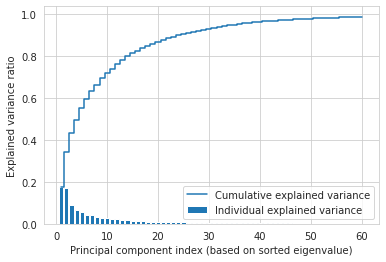

In [ ]:
  n_all=60
  pca_all = PCA(n_components=n_all)
  mini_train_pca_all = pca_all.fit_transform(mini_train_data)

  x_axis = range(1,n_all+1)
  y_axis = pca_all.explained_variance_ratio_
  plt.bar(x_axis, y_axis, label='Individual explained variance')
  plt.step(x_axis, np.cumsum(y_axis), where='mid', label='Cumulative explained variance')

  plt.legend()
  plt.ylabel('Explained variance ratio');
  plt.xlabel('Principal component index (based on sorted eigenvalue)');


In [ ]:
pipe_slr = make_pipeline(PCA(n_components=25),LinearRegression())
pipe_slr.fit(mini_train_data, mini_train_labels.ravel())
y_pred_slr = pipe_slr.predict(dev_data)
y_pred_slr_aux = np.where(y_pred_slr >= 0.5, 1, 0)
error = (dev_labels.ravel() != y_pred_slr_aux).sum()/len(y_pred_slr_aux)
print('Test Accuracy: %.3f' % (1-error))

Test Accuracy: 0.512


In [ ]:
# ols w/PCA
horse_race['model'].append("OLS w/PCA")
horse_race['accuracy'].append((1-error))
horse_race['utility'].append(utility(dev_weights,dev_resps,y_pred_slr_aux,dev_dates  ))
print(tabulate(pd.DataFrame(horse_race), tablefmt="pipe", headers="keys"))

|    | model                    |   accuracy |   utility |
|---:|:-------------------------|-----------:|----------:|
|  0 | Random Forest - All      |    0.5084  |   438.881 |
|  1 | Random Forest - Linear   |    0.50782 |   479.887 |
|  2 | Random Forest - Logistic |    0.5037  |   424.466 |
|  3 | 1-NN                     |    0.50612 |   429.17  |
|  4 | 3-NN                     |    0.50954 |   389.766 |
|  5 | 5-NN                     |    0.51038 |   435.564 |
|  6 | 7-NN                     |    0.511   |   403.517 |
|  7 | 9-NN                     |    0.50772 |   407.481 |
|  8 | NB Bernoulli             |    0.5264  |   462.223 |
|  9 | NB Multinomial           |    0.52196 |   372.814 |
| 10 | OLS w/PCA                |    0.51224 |   240.368 |


### Logistic Regression with PCA

In [ ]:
pca = PCA(n_components=25, svd_solver='full')
pca.fit(mini_train_data)
print(pca.explained_variance_ratio_)
print('\nPercentage of the variance explained by the first %.0f components: %.2f' % (pca.n_components_,pca.explained_variance_ratio_.sum()))

[0.17428033 0.16856582 0.08885598 0.06476538 0.05646671 0.04170069
 0.03965531 0.03047246 0.02907398 0.02542794 0.02129209 0.0207721
 0.01986265 0.01857002 0.0141855  0.01253971 0.01163271 0.01097178
 0.01004188 0.00954504 0.00853685 0.00798363 0.00738177 0.00691578
 0.00631778]

Percentage of the variance explained by the first 25 components: 0.91


In [ ]:
pipe_lr = make_pipeline(PCA(n_components=25),LogisticRegression(random_state=1, solver = 'lbfgs'))
pipe_lr.fit(mini_train_data, mini_train_labels.ravel())
y_pred_lr = pipe_lr.predict(dev_data)
error_lr = (dev_labels.ravel() != y_pred_lr).sum()/len(y_pred_lr)
print('Test Accuracy: %.3f' % pipe_lr.score(dev_data, dev_labels))

Test Accuracy: 0.512


In [ ]:
# Logistic w/PCA
horse_race['model'].append("Logistic w/PCA")
horse_race['accuracy'].append((1-error_lr))
horse_race['utility'].append(utility(dev_weights,dev_resps,y_pred_lr,dev_dates  ))
print(tabulate(pd.DataFrame(horse_race), tablefmt="pipe", headers="keys"))

|    | model                    |   accuracy |   utility |
|---:|:-------------------------|-----------:|----------:|
|  0 | Random Forest - All      |    0.5084  |   438.881 |
|  1 | Random Forest - Linear   |    0.50782 |   479.887 |
|  2 | Random Forest - Logistic |    0.5037  |   424.466 |
|  3 | 1-NN                     |    0.50612 |   429.17  |
|  4 | 3-NN                     |    0.50954 |   389.766 |
|  5 | 5-NN                     |    0.51038 |   435.564 |
|  6 | 7-NN                     |    0.511   |   403.517 |
|  7 | 9-NN                     |    0.50772 |   407.481 |
|  8 | NB Bernoulli             |    0.5264  |   462.223 |
|  9 | NB Multinomial           |    0.52196 |   372.814 |
| 10 | OLS w/PCA                |    0.51224 |   240.368 |
| 11 | Logistic w/PCA           |    0.51178 |   209.837 |


### OLS

In [ ]:
slr = LinearRegression()
slr.fit(mini_train_data, mini_train_labels.ravel())
y_pred_ols = slr.predict(dev_data)
y_pred_ols_aux = np.where(y_pred_ols >= 0.5, 1, 0)
error_ols = (dev_labels.ravel() != y_pred_ols_aux).sum()/len(y_pred_ols_aux)
print('Test Accuracy: %.4f' % (1-error_ols))

Test Accuracy: 0.5166


In [ ]:
# ols
horse_race['model'].append("OLS")
horse_race['accuracy'].append((1-error_ols))
horse_race['utility'].append(utility(dev_weights,dev_resps,y_pred_ols_aux,dev_dates  ))
print(tabulate(pd.DataFrame(horse_race), tablefmt="pipe", headers="keys"))

|    | model                    |   accuracy |   utility |
|---:|:-------------------------|-----------:|----------:|
|  0 | Random Forest - All      |    0.5084  |   438.881 |
|  1 | Random Forest - Linear   |    0.50782 |   479.887 |
|  2 | Random Forest - Logistic |    0.5037  |   424.466 |
|  3 | 1-NN                     |    0.50612 |   429.17  |
|  4 | 3-NN                     |    0.50954 |   389.766 |
|  5 | 5-NN                     |    0.51038 |   435.564 |
|  6 | 7-NN                     |    0.511   |   403.517 |
|  7 | 9-NN                     |    0.50772 |   407.481 |
|  8 | NB Bernoulli             |    0.5264  |   462.223 |
|  9 | NB Multinomial           |    0.52196 |   372.814 |
| 10 | OLS w/PCA                |    0.51224 |   240.368 |
| 11 | Logistic w/PCA           |    0.51178 |   209.837 |
| 12 | OLS                      |    0.51664 |   481.908 |


### Ridge Regression

In [ ]:
ridge = Ridge(alpha=0.0001)
ridge.fit(mini_train_data, mini_train_labels.ravel())
y_pred_rdg = ridge.predict(dev_data)
y_pred_rdg_aux = np.where(y_pred_rdg >= 0.5, 1, 0)
error_rdg = (dev_labels.ravel() != y_pred_rdg_aux).sum()/len(y_pred_rdg_aux)
print('Test Accuracy: %.4f' % (1-error_rdg))

Test Accuracy: 0.5166


In [ ]:
# ridge
horse_race['model'].append("Ridge Regression")
horse_race['accuracy'].append((1-error_rdg))
horse_race['utility'].append(utility(dev_weights,dev_resps,y_pred_rdg_aux,dev_dates  ))
print(tabulate(pd.DataFrame(horse_race), tablefmt="pipe", headers="keys"))

|    | model                    |   accuracy |   utility |
|---:|:-------------------------|-----------:|----------:|
|  0 | Random Forest - All      |    0.5084  |   438.881 |
|  1 | Random Forest - Linear   |    0.50782 |   479.887 |
|  2 | Random Forest - Logistic |    0.5037  |   424.466 |
|  3 | 1-NN                     |    0.50612 |   429.17  |
|  4 | 3-NN                     |    0.50954 |   389.766 |
|  5 | 5-NN                     |    0.51038 |   435.564 |
|  6 | 7-NN                     |    0.511   |   403.517 |
|  7 | 9-NN                     |    0.50772 |   407.481 |
|  8 | NB Bernoulli             |    0.5264  |   462.223 |
|  9 | NB Multinomial           |    0.52196 |   372.814 |
| 10 | OLS w/PCA                |    0.51224 |   240.368 |
| 11 | Logistic w/PCA           |    0.51178 |   209.837 |
| 12 | OLS                      |    0.51664 |   481.908 |
| 13 | Ridge Regression         |    0.51664 |   481.908 |


### Lasso

In [ ]:
lasso = Lasso(alpha=0.0001)
lasso.fit(mini_train_data, mini_train_labels.ravel())
y_pred_lasso = lasso.predict(dev_data)
y_pred_lasso_aux = np.where(y_pred_lasso >= 0.5, 1, 0)
error_lasso = (dev_labels.ravel() != y_pred_lasso_aux).sum()/len(y_pred_lasso_aux)
print('Test Accuracy: %.4f' % (1-error_lasso))
print(error_lasso)

Test Accuracy: 0.5169
0.48306


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 263.95361473513367, tolerance: 1.24908604800001
  positive)


In [ ]:
# lasso
horse_race['model'].append("Lasso")
horse_race['accuracy'].append((1-error_lasso))
horse_race['utility'].append(utility(dev_weights,dev_resps,y_pred_lasso_aux,dev_dates  ))
print(tabulate(pd.DataFrame(horse_race), tablefmt="pipe", headers="keys"))

|    | model                    |   accuracy |   utility |
|---:|:-------------------------|-----------:|----------:|
|  0 | Random Forest - All      |    0.5084  |   438.881 |
|  1 | Random Forest - Linear   |    0.50782 |   479.887 |
|  2 | Random Forest - Logistic |    0.5037  |   424.466 |
|  3 | 1-NN                     |    0.50612 |   429.17  |
|  4 | 3-NN                     |    0.50954 |   389.766 |
|  5 | 5-NN                     |    0.51038 |   435.564 |
|  6 | 7-NN                     |    0.511   |   403.517 |
|  7 | 9-NN                     |    0.50772 |   407.481 |
|  8 | NB Bernoulli             |    0.5264  |   462.223 |
|  9 | NB Multinomial           |    0.52196 |   372.814 |
| 10 | OLS w/PCA                |    0.51224 |   240.368 |
| 11 | Logistic w/PCA           |    0.51178 |   209.837 |
| 12 | OLS                      |    0.51664 |   481.908 |
| 13 | Ridge Regression         |    0.51664 |   481.908 |
| 14 | Lasso                    |    0.51694 |   461.311

### Elastic Net

In [ ]:
elanet = ElasticNet(alpha=0.0001, l1_ratio = 1)
elanet.fit(mini_train_data, mini_train_labels.ravel())
y_pred_elanet = elanet.predict(dev_data)
y_pred_elanet_aux = np.where(y_pred_elanet >= 0.5, 1, 0)
error_elanet = (dev_labels.ravel() != y_pred_elanet_aux).sum()/len(y_pred_elanet_aux)
print('Test Accuracy: %.3f' % (1-error_elanet))
print(error_elanet)

Test Accuracy: 0.517
0.48306


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 263.95361473513367, tolerance: 1.24908604800001
  positive)


In [ ]:
# elastic net
horse_race['model'].append("Elastic Net")
horse_race['accuracy'].append((1-error_elanet))
horse_race['utility'].append(utility(dev_weights,dev_resps,y_pred_elanet_aux,dev_dates  ))
print(tabulate(pd.DataFrame(horse_race), tablefmt="pipe", headers="keys"))

|    | model                    |   accuracy |   utility |
|---:|:-------------------------|-----------:|----------:|
|  0 | Random Forest - All      |    0.5084  |   438.881 |
|  1 | Random Forest - Linear   |    0.50782 |   479.887 |
|  2 | Random Forest - Logistic |    0.5037  |   424.466 |
|  3 | 1-NN                     |    0.50612 |   429.17  |
|  4 | 3-NN                     |    0.50954 |   389.766 |
|  5 | 5-NN                     |    0.51038 |   435.564 |
|  6 | 7-NN                     |    0.511   |   403.517 |
|  7 | 9-NN                     |    0.50772 |   407.481 |
|  8 | NB Bernoulli             |    0.5264  |   462.223 |
|  9 | NB Multinomial           |    0.52196 |   372.814 |
| 10 | OLS w/PCA                |    0.51224 |   240.368 |
| 11 | Logistic w/PCA           |    0.51178 |   209.837 |
| 12 | OLS                      |    0.51664 |   481.908 |
| 13 | Ridge Regression         |    0.51664 |   481.908 |
| 14 | Lasso                    |    0.51694 |   461.311

### Comparison of Runtime and Accuracy

In [ ]:
test_size = 10000
train_sizes = list(range(20000,400000,20000))

#Define vectors to hold accuracies and runtimes for each model
rfaf_acc = []
rfaf_t = []

rflr_acc = []
rflr_acc = []
knn_acc = []

bnb_acc = []
bnb_t = []

mnb_acc = []
mnb_t = []

olspca_acc = []
lrpca_acc = []

ols_acc = []
ols_t = []

rr_acc = []
rr_t = []

lass_acc = []
lass_t = []

en_acc = []
en_t = []

accuracies = []

for i in train_sizes:
  """Test all models on a range of training data sizes. Compute runtime and accuracy"""

  ts_train_data, ts_train_labels = X_train[0:i], y_train[0:i]
  ts_test_data, ts_test_labels = X_train[i:i+test_size], y_train[i:i+test_size]
  
  #Random Forest
  t1 = time.time()
  clf = RandomForestClassifier(n_estimators = 10, random_state = 0, n_jobs = -1)
  clf = clf.fit(ts_train_data, ts_train_labels.ravel())
  y_pred_rf = clf.predict(ts_test_data)
  y_pred_rf_aux = np.where(y_pred_rf >= 0.5, 1, 0)
  error_rf = (ts_test_labels.ravel() != y_pred_rf_aux).sum()/len(y_pred_rf_aux)
  t2 = time.time()
  rfaf_acc.append(1-error_rf)
  rfaf_t.append(t2-t1)

  #BNB
  t1 = time.time()
  bnb = BernoulliNB()
  bnb.fit(ts_train_data, ts_train_labels.ravel())
  y_pred_bnb = bnb.predict(ts_test_data)
  y_pred_bnb_aux = np.where(y_pred_bnb >= 0.5, 1, 0)
  error_bnb = (ts_test_labels.ravel() != y_pred_bnb_aux).sum()/len(y_pred_bnb_aux)
  t2 = time.time()
  bnb_acc.append(1-error_bnb)
  bnb_t.append(t2-t1)

  #OLS
  t1 = time.time()
  slr = LinearRegression()
  slr.fit(ts_train_data, ts_train_labels.ravel())
  y_pred_ols = slr.predict(ts_test_data)
  y_pred_ols_aux = np.where(y_pred_ols >= 0.5, 1, 0)
  error_ols = (ts_test_labels.ravel() != y_pred_ols_aux).sum()/len(y_pred_ols_aux)
  t2 = time.time()
  ols_acc.append(1-error_ols)
  ols_t.append(t2-t1)

  # Ridge Regression
  t1 = time.time()
  ridge = Ridge(alpha=1.0)
  ridge.fit(ts_train_data, ts_train_labels.ravel())
  y_pred_rdg = ridge.predict(ts_test_data)
  y_pred_rdg_aux = np.where(y_pred_rdg >= 0.5, 1, 0)
  error_rdg = (ts_test_labels.ravel() != y_pred_rdg_aux).sum()/len(y_pred_rdg_aux)
  t2 = time.time()
  rr_acc.append(1-error_rdg)
  rr_t.append(t2-t1)

  # Lasso
  t1 = time.time()
  lasso = Ridge(alpha=1.0)
  lasso.fit(ts_train_data, ts_train_labels.ravel())
  y_pred_lasso = lasso.predict(ts_test_data)
  y_pred_lasso_aux = np.where(y_pred_lasso >= 0.5, 1, 0)
  error_lasso = (ts_test_labels.ravel() != y_pred_lasso_aux).sum()/len(y_pred_lasso_aux)
  t2 = time.time()
  lass_acc.append(1-error_lasso)
  lass_t.append(t2-t1)

  # Elastic Net
  t1 = time.time()
  elanet = ElasticNet(alpha=1.0, l1_ratio = 0.5)
  elanet.fit(ts_train_data, ts_train_labels.ravel())
  y_pred_elanet = elanet.predict(ts_test_data)
  y_pred_elanet_aux = np.where(y_pred_elanet >= 0.5, 1, 0)
  error_elanet = (ts_test_labels.ravel() != y_pred_elanet_aux).sum()/len(y_pred_elanet_aux)
  t2 = time.time()
  en_acc.append(1-error_elanet)
  en_t.append(t2-t1)

  print("Loop Complete")


Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete


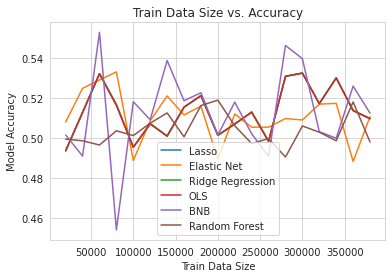

In [ ]:
#Plot Train Data Size vs Accuracy for all models
plt.plot(train_sizes, lass_acc)
plt.plot(train_sizes, en_acc)
plt.plot(train_sizes, rr_acc)
plt.plot(train_sizes, ols_acc)
plt.plot(train_sizes, bnb_acc)
plt.plot(train_sizes, rfaf_acc)
plt.title("Train Data Size vs. Accuracy")
plt.legend(['Lasso','Elastic Net','Ridge Regression','OLS','BNB','Random Forest'])
plt.xlabel("Train Data Size")
plt.ylabel("Model Accuracy")
plt.show()

In [ ]:
#Plot Train Data Size vs. Runtime for all models
plt.plot(train_sizes, lass_t)
plt.plot(train_sizes, en_t)
plt.plot(train_sizes, rr_t)
plt.plot(train_sizes, ols_t)
plt.plot(train_sizes, bnb_t)
plt.plot(train_sizes, rfaf_t)
plt.title("Train Data Size vs. Runtime")
plt.legend(['Lasso','Elastic Net','Ridge Regression','OLS','BNB', 'Random Forest'])
plt.xlabel("Train Data Size")
plt.ylabel("Runtime")
plt.show()

## Long Short-Term Memory Neural Network (LSTM)

RNN are type of neural networks which uses sequential data to predict the next likely scenario.  A recurrent neural network can be thought of as multiple copies of the same network, each passing a message  to next cell in a repeated fashion.  The idea that is to be able to connect previous information to the present task.  It is very good for speech recognition and text processing.  Long Short Term Memory networks are a special kind of recurrent neural network.  It is capable of learning long-term relationships between data points.  




### Why LSTM is widely used for market prediction?


*   Financial time-series data is a type of sequential data where there is a need to establish long associations based on past experience 
*   Predicting the direction of the financial markets is the key activity for major institutions.  The stock market volatility depends on multiple factors and the relationship between factors is non-linear.
*   Econometric (ARIMA, GARCH) or risk-neutral models are less effective with regime changes.  GARCH is this statistical model to predict the volatility of returns using the square of pass returns and volatility.  For example, if a change regime occurs from recession to inflation, a GARCH model will have less predictive power.
*  LSTM neural networks are suitable for random nonstationary sequences with a lot of noise such as stock-price time series. By non-stationary, I mean the mean, variance and correlation of the time-series varies all the time.  Our data includes intraday trades so what happens during a normal trading day has less to do with the more fundamental factors moving the market but more to do with things related to trading activity such as volume, supply and demand and disruptions in the market.
*  Avoids long-term dependence issues due to it storages information.  Long-term dependence describes the long term correlation structure between long lags
•	Good non-linear approximation and the ability of self-learning


To run the model, we first check whether GPUs are available in collab and load keras packages

In [ ]:
#LSTM model

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout

Found GPU at: /device:GPU:0


To reduce the dimensionality, we applied PCA given that only 25 features explain at least 90% of the variance 

In [ ]:
pca_lstm = PCA(n_components=25)
mini_train_pca_lstm = pca_lstm.fit_transform(mini_train_data)
dev_data_pca_lstm = pca_lstm.transform(dev_data)

In [ ]:
#Reshape the data into 3-D array
with_pca=True

if with_pca:
  mini_train_data_3d = np.reshape(mini_train_pca_lstm, (mini_train_pca_lstm.shape[0],mini_train_pca_lstm.shape[1],1))
  dev_data_3d = np.reshape(dev_data_pca_lstm, (dev_data_pca_lstm.shape[0],dev_data_pca_lstm.shape[1],1))
else:
  mini_train_data_3d = np.reshape(mini_train_data, (mini_train_data.shape[0],mini_train_data.shape[1],1))
  dev_data_3d = np.reshape(dev_data, (dev_data.shape[0],dev_data.shape[1],1)) 

We set up a LSTM using 4 layer each with a dropout layer. Units are set to 25 which is the dimensionality of the output space. A dropout layer of 0.2 means that a 20 % of the layers will be dropped out in the process. We also have a final “dense” layer with a sigmoid activation function and an output equal to 1 which means that the final output is a "boolean" vector

In [ ]:
# Initialising the RNN
model = Sequential()

model.add(LSTM(units = 25, return_sequences = True, input_shape = (mini_train_data_3d.shape[1], 1)))
model.add(Dropout(0.1))

# Adding a second LSTM layer and Dropout layer
model.add(LSTM(units = 25,  return_sequences = True))
model.add(Dropout(0.1))

# Adding a third LSTM layer and Dropout layer
model.add(LSTM(units = 25,  return_sequences = True))
model.add(Dropout(0.1))

# Adding a fourth LSTM layer and and Dropout layer
model.add(LSTM(units = 25 ))
model.add(Dropout(0.1))

# Adding the output layer
# For Full connection layer we use dense
# As the output is 1D so we use unit=1
model.add(Dense(units = 1, activation='sigmoid'))


First, we need to define the batch size and the number of epoch for the model.  According to the definition of the model, the batch size is a number of samples processed before the model is updated and the number of epochs is the number of complete passes through the training dataset.  The size of a batch must be more than or equal to one and less than or equal to the number of samples in the training dataset.  For the mini training data set, we have approximately 50K entries and one day have approximately 500 entries.  To reduce some of the noise, we want to set the batch size to a number of samples equal to 1 day, 1 week and 2 weeks.

In [ ]:
#compile and fit the model on x number of epochs

epochs = [500, 2000, 100, 500, 2000, 5000, 100, 500, 2000, 5000]
batch_size = [500, 500, 3500, 3500, 3500, 3500, 7000, 7000, 7000, 7000 ]

accuracy_list = []
model_list=[]
utility_list=[]
# for i in range(len(epochs)):
#   for j in range(len(batch_size)):
for epoch, b_size in zip (epochs, batch_size):
    with tf.device('/device:GPU:0'):
      model.compile(optimizer = 'adam', loss = 'mean_squared_error')
      model.fit(mini_train_data_3d, mini_train_labels.ravel(), epochs = epoch, batch_size = b_size)
      y_pred_lstm = model.predict(dev_data_3d)
      y_pred_lstm_aux = np.where(y_pred_lstm >= 0.5, 1, 0)
      accuracy_lstm = accuracy_score(dev_labels.ravel(), y_pred_lstm_aux.ravel())
      model_list.append('LSTM '+str(epoch)+' epochs '+str(b_size)+' batch size')
      accuracy_list.append(accuracy_lstm)
      utility_list.append(utility(dev_weights,dev_resps,y_pred_lstm_aux.T[0],dev_dates  ))

Streaming output truncated to the last 5000 lines.
Epoch 3128/5000
15/15 [==============================] - 0s 22ms/step - loss: 0.1359
Epoch 3129/5000
15/15 [==============================] - 0s 23ms/step - loss: 0.1370
Epoch 3130/5000
15/15 [==============================] - 0s 22ms/step - loss: 0.1395
Epoch 3131/5000
15/15 [==============================] - 0s 22ms/step - loss: 0.1382
Epoch 3132/5000
15/15 [==============================] - 0s 22ms/step - loss: 0.1392
Epoch 3133/5000
15/15 [==============================] - 0s 22ms/step - loss: 0.1352
Epoch 3134/5000
15/15 [==============================] - 0s 22ms/step - loss: 0.1352
Epoch 3135/5000
15/15 [==============================] - 0s 22ms/step - loss: 0.1366
Epoch 3136/5000
15/15 [==============================] - 0s 22ms/step - loss: 0.1367
Epoch 3137/5000
15/15 [==============================] - 0s 22ms/step - loss: 0.1357
Epoch 3138/5000
15/15 [==============================] - 0s 22ms/step - loss: 0.1368
Epoch 3139/500

KeyboardInterrupt: ignored

In [ ]:
horse_race_lstm={}
horse_race_lstm['model']=model_list
horse_race_lstm['accuracy']=accuracy_list
horse_race_lstm['utility']=utility_list
print(tabulate(pd.DataFrame(horse_race_lstm), tablefmt="pipe", headers="keys"))

# Append to main horse_race table and print it out.
horse_race['model'].append(model_list[0])
horse_race['accuracy'].append(accuracy_list[0])
horse_race['utility'].append(utility_list[0])
print(tabulate(pd.DataFrame(horse_race), tablefmt="pipe", headers="keys"))

|    | model                            |   accuracy |   utility |
|---:|:---------------------------------|-----------:|----------:|
|  0 | LSTM 500 epochs 500 batch size   |    0.50374 |   290.263 |
|  1 | LSTM 2000 epochs 500 batch size  |    0.50258 |   351.439 |
|  2 | LSTM 100 epochs 3500 batch size  |    0.504   |   314.974 |
|  3 | LSTM 500 epochs 3500 batch size  |    0.5046  |   277.411 |
|  4 | LSTM 2000 epochs 3500 batch size |    0.50448 |   323.897 |
|  5 | LSTM 5000 epochs 3500 batch size |    0.5029  |   302.088 |
|  6 | LSTM 100 epochs 7000 batch size  |    0.50214 |   318.852 |
|  7 | LSTM 500 epochs 7000 batch size  |    0.50494 |   376.863 |
|    | model                           |   accuracy |   utility |
|---:|:--------------------------------|-----------:|----------:|
|  0 | LSTM 100 epochs 3500 batch size |    0.50516 |   472.978 |
|  1 | LSTM 100 epochs 3500 batch size |    0.50228 |   368.755 |
|  2 | LSTM 100 epochs 7000 batch size |    0.50884 |   579.203 |


Output Array in terms of Epochs, Batch Size, and Accuracy:

|    | model                            |   accuracy |   utility |
|---:|:---------------------------------|-----------:|----------:|
|  0 | LSTM 500 epochs 500 batch size   |    0.50374 |   290.263 |
|  1 | LSTM 2000 epochs 500 batch size  |    0.50258 |   351.439 |
|  2 | LSTM 100 epochs 3500 batch size  |    0.504   |   314.974 |
|  3 | LSTM 500 epochs 3500 batch size  |    0.5046  |   277.411 |
|  4 | LSTM 2000 epochs 3500 batch size |    0.50448 |   323.897 |
|  5 | LSTM 5000 epochs 3500 batch size |    0.5029  |   302.088 |
|  6 | LSTM 100 epochs 7000 batch size  |    0.50214 |   318.852 |
|  7 | LSTM 500 epochs 7000 batch size  |    0.50494 |   376.863 |

- Best accuracy of LSTM: 50.5% with 500 Epochs and 7000 batch size.

- Higher epoch sizes do not improve the accuracy of the model (e.g. 2000). Best is still around 51.3% accuracy.

## Convolutional Neural Network (CNN)




We picked CNN as one of our in-depth models because it is well documented in literature for: 1) its ability to simplify complex data into binary output 2) having more hidden layers vs. traditional neural networks (more hidden layers translates to more features the CNN can extract and recognize from the input data), and 3) ability to capture micro-changes of data for different time periods.

Source:
- Chen, Sheng, and Hongxiang He. “Stock Prediction Using Convolutional Neural Network.” IOP Conference Series: Materials Science and Engineering, vol. 435, 2018, p. 012026. Crossref, doi:10.1088/1757-899x/435/1/012026. <https://iopscience.iop.org/article/10.1088/1757-899X/435/1/012026/pdf#:~:text=Besides%2C%20it%20has%20shown%20that,of%20data%20at%20different%20time.>

In [ ]:
# Import libraries needed for CNN
#import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, Conv2D, MaxPooling2D

We implemented a "pseudo grid search" for hyperparameter tuning in order to balance between minimizing runtime and getting to the best parameters as soon as possible.

We have reflected in the commented code below all of our attempts. We left some of the better parameters in the code, because many of the previously tested parameters (in the commented code) generated low to NA utility or validation losses greater than 1.

Xtrain shape: (50000, 126)
Ytrain shape: (50000, 1)
Xtest shape: (50000, 126)
Ytest shape: (50000, 1)
Xtrain NEW shape: (50000, 126, 1)
Xtest NEW shape: (50000, 126, 1)
Ytrain NEW shape: (50000, 1, 1)
Ytest NEW shape: (50000, 1, 1)
Epoch 1/3
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6955 - accuracy: 0.5127 - val_loss: 0.6935 - val_accuracy: 0.5078
Epoch 2/3
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6909 - accuracy: 0.5250 - val_loss: 0.6942 - val_accuracy: 0.5071
Epoch 3/3
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6891 - accuracy: 0.5296 - val_loss: 0.6941 - val_accuracy: 0.5043


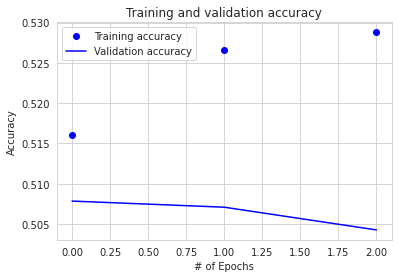

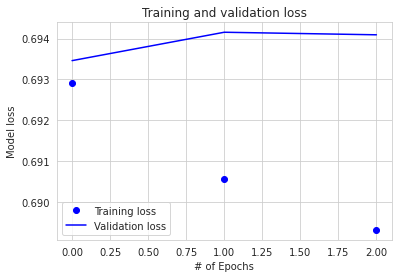

Validation Accuracy List for each epoch: [0.5078399777412415, 0.5070800185203552, 0.5042600035667419]
Devdata NEW shape: (50000, 126, 1)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Predicted classes:  [1 1 1 ... 1 0 1]
|    | model     |   accuracy |   utility |   kernel_size |   density_size |   batch_size |   epoch_size |
|---:|:----------|-----------:|----------:|--------------:|---------------:|-------------:|-------------:|
|  0 | CNN Model |    0.50784 |   315.106 |             1 |              2 |           50 |            3 |
Epoch 1/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6887 - accuracy: 0.5307 - val_loss: 0.6944 - val_accuracy: 0.5063
Epoch 2/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6882 - accuracy: 0.5320 - val_loss: 0.6954 - val_accuracy: 0.5055
Epoch 3/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6877 - accuracy: 0.5337 - val_loss: 0.6943 - val_accuracy: 0.5044
Epoch 4/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6872 - accuracy: 0.5375 - val_loss: 0.6942 - val_accuracy: 0.5077
Epoch 5/10
1000/1000 [==============================] - 4s 4ms/st

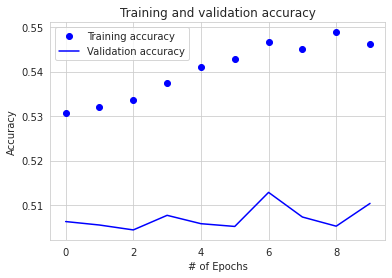

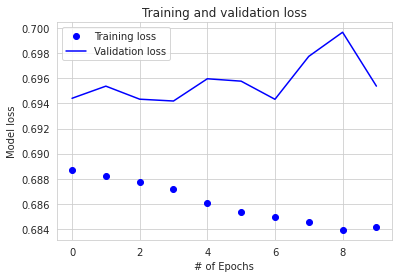

Validation Accuracy List for each epoch: [0.5062800049781799, 0.5055000185966492, 0.5044000148773193, 0.5076799988746643, 0.5058000087738037, 0.5051800012588501, 0.5128399729728699, 0.5073000192642212, 0.5052400231361389, 0.5103600025177002]
Devdata NEW shape: (50000, 126, 1)
Predicted classes:  [1 1 1 ... 1 0 1]
|    | model     |   accuracy |   utility |   kernel_size |   density_size |   batch_size |   epoch_size |
|---:|:----------|-----------:|----------:|--------------:|---------------:|-------------:|-------------:|
|  0 | CNN Model |    0.50784 |   315.106 |             1 |              2 |           50 |            3 |
|  1 | CNN Model |    0.51284 |   445.753 |             1 |              2 |           50 |           10 |
Epoch 1/3
15/15 [==============================] - 1s 50ms/step - loss: 0.6827 - accuracy: 0.5478 - val_loss: 0.6956 - val_accuracy: 0.5105
Epoch 2/3
15/15 [==============================] - 1s 35ms/step - loss: 0.6824 - accuracy: 0.5479 - val_loss: 0.6957 

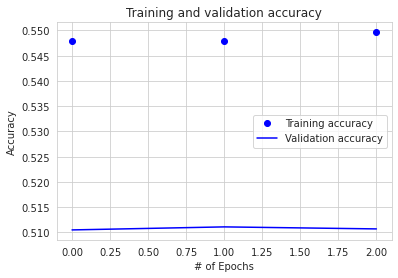

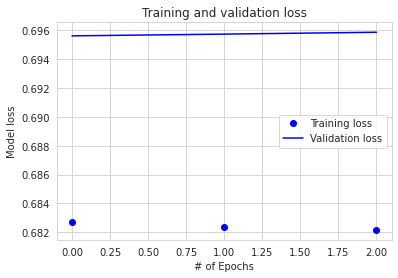

Validation Accuracy List for each epoch: [0.5105000138282776, 0.5110999941825867, 0.510699987411499]
Devdata NEW shape: (50000, 126, 1)
Predicted classes:  [0 1 1 ... 1 0 1]
|    | model     |   accuracy |   utility |   kernel_size |   density_size |   batch_size |   epoch_size |
|---:|:----------|-----------:|----------:|--------------:|---------------:|-------------:|-------------:|
|  0 | CNN Model |    0.50784 |   315.106 |             1 |              2 |           50 |            3 |
|  1 | CNN Model |    0.51284 |   445.753 |             1 |              2 |           50 |           10 |
|  2 | CNN Model |    0.5111  |   425.863 |             1 |              2 |         3500 |            3 |
Epoch 1/10
15/15 [==============================] - 1s 42ms/step - loss: 0.6820 - accuracy: 0.5503 - val_loss: 0.6961 - val_accuracy: 0.5111
Epoch 2/10
15/15 [==============================] - 1s 35ms/step - loss: 0.6819 - accuracy: 0.5507 - val_loss: 0.6963 - val_accuracy: 0.5114
Epoch 3/1

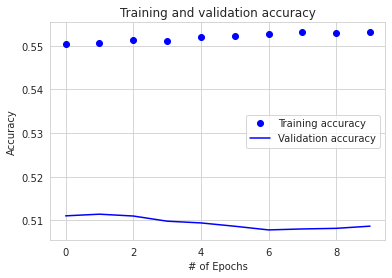

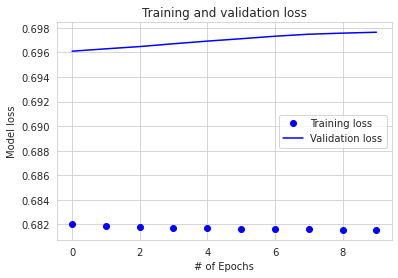

Validation Accuracy List for each epoch: [0.5110599994659424, 0.5114399790763855, 0.5110200047492981, 0.5098400115966797, 0.509440004825592, 0.508679986000061, 0.5078399777412415, 0.5080599784851074, 0.5081999897956848, 0.5087000131607056]
Devdata NEW shape: (50000, 126, 1)
Predicted classes:  [1 1 1 ... 1 0 1]
|    | model     |   accuracy |   utility |   kernel_size |   density_size |   batch_size |   epoch_size |
|---:|:----------|-----------:|----------:|--------------:|---------------:|-------------:|-------------:|
|  0 | CNN Model |    0.50784 |   315.106 |             1 |              2 |           50 |            3 |
|  1 | CNN Model |    0.51284 |   445.753 |             1 |              2 |           50 |           10 |
|  2 | CNN Model |    0.5111  |   425.863 |             1 |              2 |         3500 |            3 |
|  3 | CNN Model |    0.51144 |   394.985 |             1 |              2 |         3500 |           10 |
Epoch 1/3
1000/1000 [========================

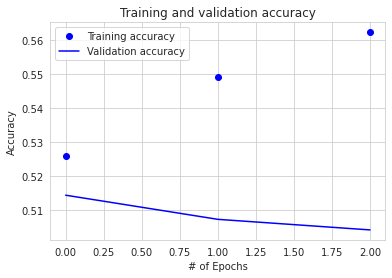

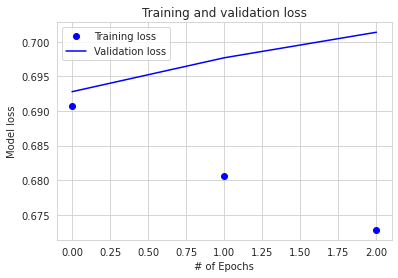

Validation Accuracy List for each epoch: [0.5142999887466431, 0.5071799755096436, 0.5040599703788757]
Devdata NEW shape: (50000, 126, 1)
Predicted classes:  [1 1 0 ... 0 1 0]
|    | model     |   accuracy |   utility |   kernel_size |   density_size |   batch_size |   epoch_size |
|---:|:----------|-----------:|----------:|--------------:|---------------:|-------------:|-------------:|
|  0 | CNN Model |    0.50784 |   315.106 |             1 |              2 |           50 |            3 |
|  1 | CNN Model |    0.51284 |   445.753 |             1 |              2 |           50 |           10 |
|  2 | CNN Model |    0.5111  |   425.863 |             1 |              2 |         3500 |            3 |
|  3 | CNN Model |    0.51144 |   394.985 |             1 |              2 |         3500 |           10 |
|  4 | CNN Model |    0.5143  |   352.344 |             3 |              2 |           50 |            3 |
Epoch 1/10
1000/1000 [==============================] - 4s 4ms/step - loss: 

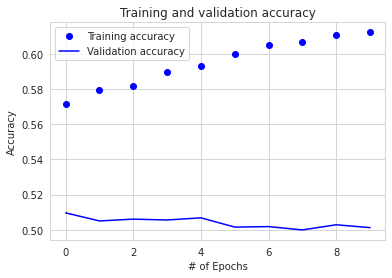

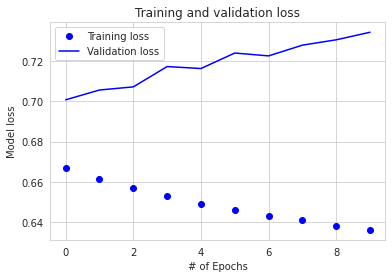

Validation Accuracy List for each epoch: [0.5096200108528137, 0.5050399899482727, 0.506060004234314, 0.5055800080299377, 0.5067999958992004, 0.5015400052070618, 0.5018200278282166, 0.49994000792503357, 0.5028600096702576, 0.5012400150299072]
Devdata NEW shape: (50000, 126, 1)
Predicted classes:  [0 1 0 ... 0 1 0]
|    | model     |   accuracy |   utility |   kernel_size |   density_size |   batch_size |   epoch_size |
|---:|:----------|-----------:|----------:|--------------:|---------------:|-------------:|-------------:|
|  0 | CNN Model |    0.50784 |   315.106 |             1 |              2 |           50 |            3 |
|  1 | CNN Model |    0.51284 |   445.753 |             1 |              2 |           50 |           10 |
|  2 | CNN Model |    0.5111  |   425.863 |             1 |              2 |         3500 |            3 |
|  3 | CNN Model |    0.51144 |   394.985 |             1 |              2 |         3500 |           10 |
|  4 | CNN Model |    0.5143  |   352.344 |

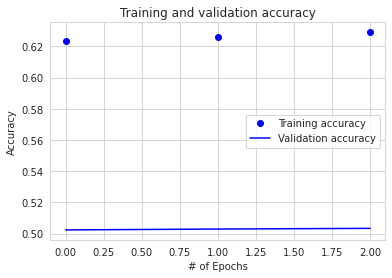

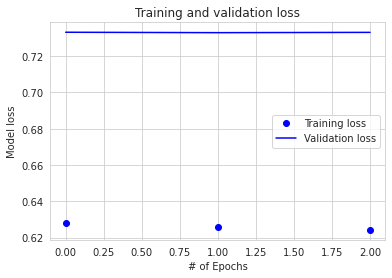

Validation Accuracy List for each epoch: [0.5023000240325928, 0.5028600096702576, 0.5033000111579895]
Devdata NEW shape: (50000, 126, 1)
Predicted classes:  [0 1 1 ... 0 1 0]
|    | model     |   accuracy |   utility |   kernel_size |   density_size |   batch_size |   epoch_size |
|---:|:----------|-----------:|----------:|--------------:|---------------:|-------------:|-------------:|
|  0 | CNN Model |    0.50784 |   315.106 |             1 |              2 |           50 |            3 |
|  1 | CNN Model |    0.51284 |   445.753 |             1 |              2 |           50 |           10 |
|  2 | CNN Model |    0.5111  |   425.863 |             1 |              2 |         3500 |            3 |
|  3 | CNN Model |    0.51144 |   394.985 |             1 |              2 |         3500 |           10 |
|  4 | CNN Model |    0.5143  |   352.344 |             3 |              2 |           50 |            3 |
|  5 | CNN Model |    0.50962 |   262.09  |             3 |              2 |

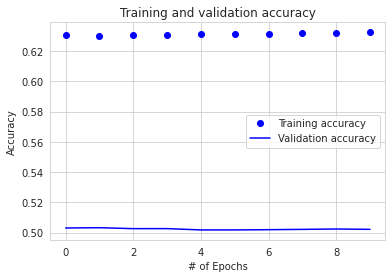

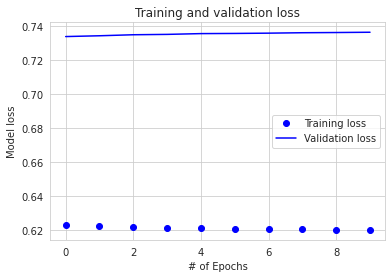

Validation Accuracy List for each epoch: [0.5030400156974792, 0.5032200217247009, 0.5026000142097473, 0.5026199817657471, 0.5017600059509277, 0.5017600059509277, 0.5019199848175049, 0.5021200180053711, 0.5023599863052368, 0.5021399855613708]
Devdata NEW shape: (50000, 126, 1)
Predicted classes:  [0 1 1 ... 0 1 0]
|    | model     |   accuracy |   utility |   kernel_size |   density_size |   batch_size |   epoch_size |
|---:|:----------|-----------:|----------:|--------------:|---------------:|-------------:|-------------:|
|  0 | CNN Model |    0.50784 |   315.106 |             1 |              2 |           50 |            3 |
|  1 | CNN Model |    0.51284 |   445.753 |             1 |              2 |           50 |           10 |
|  2 | CNN Model |    0.5111  |   425.863 |             1 |              2 |         3500 |            3 |
|  3 | CNN Model |    0.51144 |   394.985 |             1 |              2 |         3500 |           10 |
|  4 | CNN Model |    0.5143  |   352.344 |

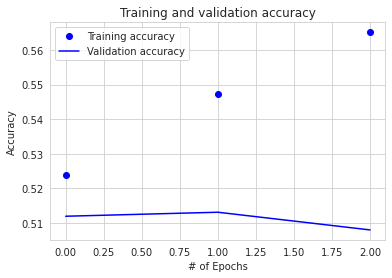

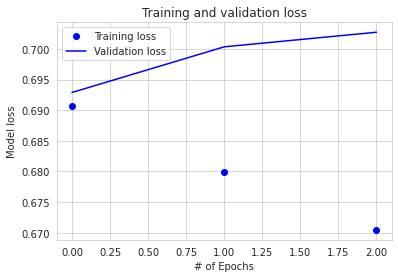

Validation Accuracy List for each epoch: [0.5118799805641174, 0.5130400061607361, 0.5079200267791748]
Devdata NEW shape: (50000, 126, 1)
Predicted classes:  [0 1 0 ... 1 1 1]
|    | model     |   accuracy |   utility |   kernel_size |   density_size |   batch_size |   epoch_size |
|---:|:----------|-----------:|----------:|--------------:|---------------:|-------------:|-------------:|
|  0 | CNN Model |    0.50784 |   315.106 |             1 |              2 |           50 |            3 |
|  1 | CNN Model |    0.51284 |   445.753 |             1 |              2 |           50 |           10 |
|  2 | CNN Model |    0.5111  |   425.863 |             1 |              2 |         3500 |            3 |
|  3 | CNN Model |    0.51144 |   394.985 |             1 |              2 |         3500 |           10 |
|  4 | CNN Model |    0.5143  |   352.344 |             3 |              2 |           50 |            3 |
|  5 | CNN Model |    0.50962 |   262.09  |             3 |              2 |

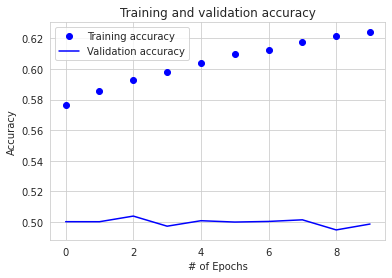

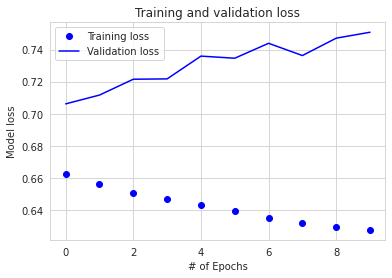

Validation Accuracy List for each epoch: [0.5001800060272217, 0.5001599788665771, 0.5038400292396545, 0.49724000692367554, 0.500819981098175, 0.49994000792503357, 0.5003399848937988, 0.5013999938964844, 0.49480000138282776, 0.4986400008201599]
Devdata NEW shape: (50000, 126, 1)
Predicted classes:  [0 1 0 ... 1 1 1]
|    | model     |   accuracy |   utility |   kernel_size |   density_size |   batch_size |   epoch_size |
|---:|:----------|-----------:|----------:|--------------:|---------------:|-------------:|-------------:|
|  0 | CNN Model |    0.50784 |   315.106 |             1 |              2 |           50 |            3 |
|  1 | CNN Model |    0.51284 |   445.753 |             1 |              2 |           50 |           10 |
|  2 | CNN Model |    0.5111  |   425.863 |             1 |              2 |         3500 |            3 |
|  3 | CNN Model |    0.51144 |   394.985 |             1 |              2 |         3500 |           10 |
|  4 | CNN Model |    0.5143  |   352.344

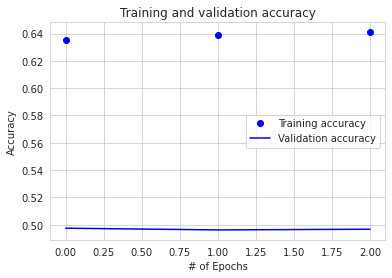

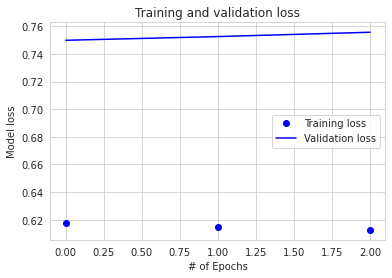

Validation Accuracy List for each epoch: [0.4974600076675415, 0.49619999527931213, 0.4966999888420105]
Devdata NEW shape: (50000, 126, 1)
Predicted classes:  [0 1 0 ... 1 1 1]
|    | model     |   accuracy |   utility |   kernel_size |   density_size |   batch_size |   epoch_size |
|---:|:----------|-----------:|----------:|--------------:|---------------:|-------------:|-------------:|
|  0 | CNN Model |    0.50784 |   315.106 |             1 |              2 |           50 |            3 |
|  1 | CNN Model |    0.51284 |   445.753 |             1 |              2 |           50 |           10 |
|  2 | CNN Model |    0.5111  |   425.863 |             1 |              2 |         3500 |            3 |
|  3 | CNN Model |    0.51144 |   394.985 |             1 |              2 |         3500 |           10 |
|  4 | CNN Model |    0.5143  |   352.344 |             3 |              2 |           50 |            3 |
|  5 | CNN Model |    0.50962 |   262.09  |             3 |              2 

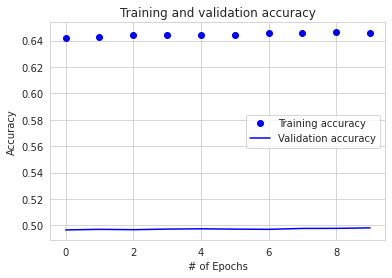

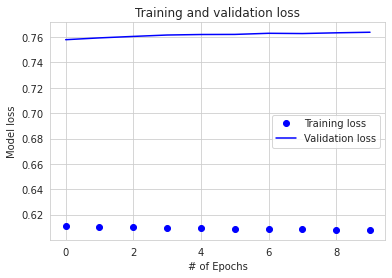

Validation Accuracy List for each epoch: [0.4964999854564667, 0.49691998958587646, 0.49667999148368835, 0.4971199929714203, 0.49733999371528625, 0.49709999561309814, 0.4969399869441986, 0.49761998653411865, 0.49768000841140747, 0.49803999066352844]
Devdata NEW shape: (50000, 126, 1)
Predicted classes:  [0 1 0 ... 1 1 1]
|    | model     |   accuracy |   utility |   kernel_size |   density_size |   batch_size |   epoch_size |
|---:|:----------|-----------:|----------:|--------------:|---------------:|-------------:|-------------:|
|  0 | CNN Model |    0.50784 |   315.106 |             1 |              2 |           50 |            3 |
|  1 | CNN Model |    0.51284 |   445.753 |             1 |              2 |           50 |           10 |
|  2 | CNN Model |    0.5111  |   425.863 |             1 |              2 |         3500 |            3 |
|  3 | CNN Model |    0.51144 |   394.985 |             1 |              2 |         3500 |           10 |
|  4 | CNN Model |    0.5143  |   35

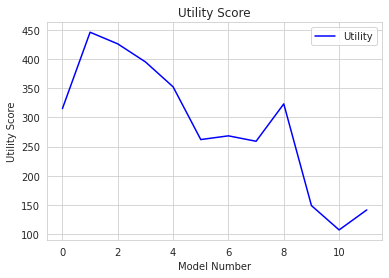

In [ ]:
# Define different sizes for trial and error
n_size = [50000]
# Tried [20000, 50000, 70000]
kernel_sizes = [1, 3, 5]
# Tried [1, 3, 5, 10]
dense_sizes = [2]
# Tried [2, 3, 4]
batch_sizes = [50, 3500]
epoch_sizes = [3, 10]

# Create empty dict exclusive to CNN to save accuracy, utilities, and parameters to perform hyperparameter tuning later
horse_race_cnn = {'model' : [], 'accuracy' : [], 'utility' : [], 
             'kernel_size' : [], 'density_size' : [], 'batch_size' : [], 'epoch_size' : []}

# Source: https://webcache.googleusercontent.com/search?q=cache:O_aNQyJ29XMJ:https://missinglink.ai/guides/convolutional-neural-networks/python-convolutional-neural-network-creating-cnn-keras-tensorflow-plain-python/+&cd=1&hl=en&ct=clnk&gl=us
# Source: https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5
# Source: https://towardsdatascience.com/build-your-own-convolution-neural-network-in-5-mins-4217c2cf964f
# Loop through different sizes. However, since our unique dates has a size of 50,000, we are going to stick with n=50000 in our data set.
for i in range(len(n_size)):

    # Attempted PCA to since 25 features explain 90% of the variance in the 126 features
    # However, PCA does significantly worse. Accuracy drops 1% on average and utility score drops by 100 points.
    #pca_cnn = PCA(n_components=25)

    # Define train and test sets, size of 50K each
    #X_train2 = pca_cnn.fit_transform(mini_train_data)
    X_train2 = mini_train_data
    y_train2 = mini_train_labels

    #X_test2 = pca_cnn.transform(dev_data)
    X_test2 = dev_data
    y_test2 = dev_labels

    # Training set
    print("Xtrain shape:", X_train2.shape)
    print("Ytrain shape:", y_train2.shape)
    # Validation data
    print("Xtest shape:", X_test2.shape)
    print("Ytest shape:", y_test2.shape)

    # Source: https://stackoverflow.com/questions/40464403/tensorflow-convolution-neural-network-with-non-image-input
    # Source: https://stackoverflow.com/questions/50918713/convolution-neural-network-using-sequential-model-for-non-image-data
    # Since we're going by a row-to-row basis in this case (using Conv1D for returns as opposed to Conv2D for images), we don't actually have a 2nd dimension. 
    # Therefore, we need to add an extra dimension and it will consider the height of the tensor to be 1, which works like a [1xn] shaped filter, striding across the entire row (only in horizontal direction).
    X_train2 = np.array(X_train2)
    X_train2 = X_train2.astype('float32').reshape(X_train2.shape[0], X_train2.shape[1], 1)
    print("Xtrain NEW shape:", X_train2.shape)
    X_test2 = np.array(X_test2)
    X_test2 = X_test2.astype('float32').reshape(X_test2.shape[0], X_test2.shape[1], 1)
    print("Xtest NEW shape:", X_test2.shape)

    # We add that extra dimension with a height of 1 to the test data as well.
    y_train2 = np.array(y_train2)
    y_train2 = y_train2.astype('float32').reshape(y_train2.shape[0], y_train2.shape[1], 1)
    print("Ytrain NEW shape:", y_train2.shape)
    y_test2 = np.array(y_test2)
    y_test2 = y_test2.astype('float32').reshape(y_test2.shape[0], y_test2.shape[1], 1)
    print("Ytest NEW shape:", y_test2.shape)
    
    # Loop through all kernel sizes
    for j in range(len(kernel_sizes)):
        
        # Source: https://stackoverflow.com/questions/57751417/what-is-meant-by-sequential-model-in-keras#:~:text=The%20sequential%20API%20allows%20you,by%2Dlayer%20for%20most%20problems.&text=Alternatively%2C%20the%20functional%20API%20allows,the%20previous%20and%20next%20layers.
        # The Sequential model is a linear stack of layers.
        # The sequential API allows us to create models layer-by-layer for most problems.
        model = Sequential()

        # Source: https://stackoverflow.com/questions/50918713/convolution-neural-network-using-sequential-model-for-non-image-data
        # Source: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D
        # Add model layers. Again, we are using Conv1D since we are not working with images.
        # Rectified Linear Activation has been proven to work well in neural networks.
        model.add(Conv1D(64, kernel_size=kernel_sizes[j], activation='relu', input_shape=(X_train2.shape[1], 1)))
        model.add(Conv1D(32, kernel_size=kernel_sizes[j], activation='relu'))

        # Flatten serves as a connection between the convolution and dense layers.
        model.add(Flatten())

        # Loop through all density sizes
        for k in range(len(dense_sizes)):
            
            # We use sigmoid activation due to the binary nature of our outcomes: 1 if action, 0 if no action.
            model.add(Dense(dense_sizes[k], activation='sigmoid'))
        
            # Source: https://stackoverflow.com/questions/63456418/keras-valueerror-logits-and-labels-must-have-the-same-shape-none-2-vs-non
            # Compile model using accuracy to measure model performance
            # The adam optimizer adjusts the learning rate throughout training.
            # A lower loss = better model performance.
            model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

            for l in range(len(batch_sizes)):
              for m in range(len(epoch_sizes)):
                # Source: https://deepai.org/machine-learning-glossary-and-terms/epoch
                # Train the model
                # Epochs: # of times the model will cycle through the data. The more epochs we run, the more the model will improve, up to a certain point. 
                # Performance looks like it tops out at 3 epochs.
                history = model.fit(X_train2, y_train2, batch_size=batch_sizes[l], validation_data=(X_test2, y_test2),
                          epochs=epoch_sizes[m]) #3 epochs, 50 batch size 

                # Source: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
                # Source: https://github.com/tflearn/tflearn/issues/357#:~:text=val_acc%20is%20the%20accuracy%20computed,you%20ahve%20to%20use%20batches. https://stackoverflow.com/questions/51344839/what-is-the-difference-between-the-terms-accuracy-and-validation-accuracy
                # Plot accuracy and loss over time (after each epoch iteration)
                accuracy = history.history['accuracy']
                val_accuracy = history.history['val_accuracy']
                loss = history.history['loss']
                val_loss = history.history['val_loss']
                epochs = range(len(accuracy))
                plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
                plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
                plt.title('Training and validation accuracy')
                plt.xlabel('# of Epochs')
                plt.ylabel('Accuracy')
                plt.legend()
                plt.figure()
                plt.plot(epochs, loss, 'bo', label='Training loss')
                plt.plot(epochs, val_loss, 'b', label='Validation loss')
                plt.title('Training and validation loss')
                plt.xlabel('# of Epochs')
                plt.ylabel('Model loss')
                plt.legend()
                plt.show()

                print("Validation Accuracy List for each epoch:", history.history['val_accuracy'])

                # Source: https://machinelearningmastery.com/how-to-make-classification-and-regression-predictions-for-deep-learning-models-in-keras/
                # Source: https://datascience.stackexchange.com/questions/46124/what-do-compile-fit-and-predict-do-in-keras-sequential-models
                # Similar to what we did for the x_train data above, we add a 3rd dimension (of height = 1) to dev_data.
                #dev_data2 = np.array(pca_cnn.transform(dev_data))
                dev_data2 = np.array(dev_data)
                dev_data2 = dev_data2.astype('float32').reshape(dev_data2.shape[0], dev_data2.shape[1], 1)
                print("Devdata NEW shape:", dev_data2.shape)

                # Ensure that our predictions only contain 1's and 0's.
                prediction = model.predict_classes(dev_data2)
                print('Predicted classes: ', prediction)

                # Create a horse race table that contains each CNN Model's characteristics.
                horse_race_cnn['model'].append("CNN Model")
                horse_race_cnn['kernel_size'].append(kernel_sizes[j])
                horse_race_cnn['density_size'].append(dense_sizes[k])
                horse_race_cnn['batch_size'].append(batch_sizes[l])
                horse_race_cnn['epoch_size'].append(epoch_sizes[m])
                horse_race_cnn['accuracy'].append(max(history.history['val_accuracy']))
                horse_race_cnn['utility'].append(utility(dev_weights,dev_resps, prediction,dev_dates))
                print(tabulate(pd.DataFrame(horse_race_cnn), tablefmt="pipe", headers="keys"))

# Plot Utility over 12 iterations 
plt.plot(horse_race_cnn['utility'], 'b', label='Utility')
plt.title('Utility Score')
plt.xlabel('Model Number')
plt.ylabel('Utility Score')
plt.legend()

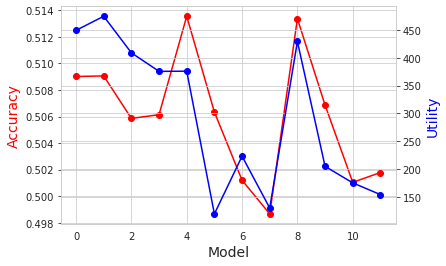

In [ ]:
# Plot CNN model's accuracy and utility over iterations
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(horse_race_cnn['accuracy'], color="red", marker="o")
# set x-axis label
ax.set_xlabel("Model",fontsize=14)
# set y-axis label
ax.set_ylabel("Accuracy",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(horse_race_cnn['utility'], color="blue", marker="o")
ax2.set_ylabel("Utility",color="blue",fontsize=14)

plt.show()

In [ ]:
#print(horse_race_cnn['accuracy'])
#print(horse_race_cnn['utility'])

# Append the average utility score's CNN to the main horse race table.
# Find average out of all CNN models.
# print(np.mean(horse_race_cnn['accuracy']))
# print(np.mean(horse_race_cnn['utility']))

# Find the best (max) utility out of all CNN models and retrieve its index.
cnn_max_utility_index = horse_race_cnn['utility'].index(max(horse_race_cnn['utility']))
print("Index:", cnn_max_utility_index)

# Append to main horse_race table and print it out.
horse_race['model'].append("CNN Model")
horse_race['accuracy'].append(horse_race_cnn['accuracy'][cnn_max_utility_index])
horse_race['utility'].append(horse_race_cnn['utility'][cnn_max_utility_index])
print(tabulate(pd.DataFrame(horse_race), tablefmt="pipe", headers="keys"))

Index: 1
|    | model                          |   accuracy |   utility |
|---:|:-------------------------------|-----------:|----------:|
|  0 | Random Forest - All            |    0.5084  |   438.881 |
|  1 | NB Bernoulli                   |    0.5264  |   462.223 |
|  2 | NB Multinomial                 |    0.52196 |   372.814 |
|  3 | OLS w/PCA                      |    0.51204 |   236.766 |
|  4 | Logistic w/PCA                 |    0.5121  |   213.386 |
|  5 | OLS                            |    0.51664 |   481.908 |
|  6 | Ridge Regression               |    0.51682 |   485.005 |
|  7 | Lasso                          |    0.51682 |   485.005 |
|  8 | Elastic Net                    |    0.50558 |   591.102 |
|  9 | LSTM 50 epochs 3500 batch size |    0.50788 |   429.35  |
| 10 | CNN Model                      |    0.50606 |   466.072 |
| 11 | CNN Model                      |    0.50906 |   474.608 |


In [ ]:
# Other Code / Appendix:

# temp = [107.66, 474.94, 456.73, 415.86, 104.078, 150.877, 151.3, 116, 456.6, 383.9, 406.8, 384.83]
# plt.plot(temp, 'b', label='Utility')
# plt.title('Utility Score')
# plt.ylabel('Utility Score')
# plt.xlabel('Model Number')
# plt.legend()

# temp2 = [0.50768, 0.5111, 0.51014, 0.5105, 0.50914, 0.50598, 0.49746, 0.49864, 0.50872, 0.50666, 0.50252, 0.50174]
# plt.plot(temp2, 'b', label='Accuracy')
# plt.title('Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Model Number')
# plt.yticks(np.arange(0.45, 0.60, 0.01))
# plt.legend()

## Gaussian Mixture Model with Principal Component Analysis (GMM/PCA)

### Generate a GMM of varying component counts and covariance types
Notice that the model appears to be performing well with 2-3 GMM Components and tied covariance type. We'll move forward with 3-component models due to its slight edge in utility score.

In [ ]:
  accuracies = []

  for i in ['spherical','diag','tied','full']:
    for j in range(2,5):   
        #Generate 2 GMM models, one for positive data, one for negative
        gm_pos = GaussianMixture(n_components=j,covariance_type=i,random_state=12345)
        gm_neg = GaussianMixture(n_components=j,covariance_type=i,random_state=12345)

        #Separate data into positive and negative values
        lab = mini_train_labels.reshape(-1,)
        pos_dat = mini_train_data[lab==1]
        neg_dat = mini_train_data[lab==0]

        #Fit the two GMM models
        gm_pos.fit(pos_dat)
        gm_neg.fit(neg_dat)

        #Calculate log liklihood using both models
        pos_pred = gm_pos.score_samples(test_data)
        neg_pred = gm_neg.score_samples(test_data)

        #Label determination
        pred = (pos_pred > neg_pred) * 1

        #Calculate accuracy
        lab=test_labels.reshape(-1,)
        count_matches = np.sum((pred==lab))
        acc = count_matches/pred.shape[0]
        accuracies.append(acc)

        #Calculate Utility
        gmm_util = utility(test_weights, test_resps, pred, test_dates)
        print("| Cov Type:",i[0:4],"| GMM Components:",j,"| Accuracy",acc," Utility",gmm_util)

| Cov Type: sphe | GMM Components: 2 | Accuracy 0.5047  Utility -0.0
| Cov Type: sphe | GMM Components: 3 | Accuracy 0.5032  Utility -0.0
| Cov Type: sphe | GMM Components: 4 | Accuracy 0.50135  Utility -0.0
| Cov Type: diag | GMM Components: 2 | Accuracy 0.5094  Utility -0.0
| Cov Type: diag | GMM Components: 3 | Accuracy 0.50095  Utility 4.785256392664279
| Cov Type: diag | GMM Components: 4 | Accuracy 0.49665  Utility -0.0
| Cov Type: tied | GMM Components: 2 | Accuracy 0.52465  Utility 156.91498349482248
| Cov Type: tied | GMM Components: 3 | Accuracy 0.5283  Utility 176.37929711436408
| Cov Type: tied | GMM Components: 4 | Accuracy 0.48525  Utility 91.17764585097495
| Cov Type: full | GMM Components: 2 | Accuracy 0.5003  Utility 87.94874307018519
| Cov Type: full | GMM Components: 3 | Accuracy 0.50545  Utility 140.00897363762226
| Cov Type: full | GMM Components: 4 | Accuracy 0.521  Utility 231.5731075643348


In [ ]:
gm = GaussianMixture(n_components=j, covariance_type=i, random_state=12345)
gm.fit(mini_train_data,mini_train_labels)
pred = gm.predict(test_data)

[3 1 3 ... 2 2 3]
[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [0]]


### Implement a Temporal Gridsearch
So far the Gaussian Mixture has already shown an accuracy above 50%, but this was only evaluated on a small section of the training data. We will perform a gridsearch along the time axis to verify that this type of model works equally throughout the dataset. Note: This type of Gridsearch does not optimize for hyperparameters, it merely evaluates consistancy across the entire range of the data.

In [ ]:

#Define a train data size, test data size
train_size = 50000
test_size = 20000

#Create a list of sequential train-test data slices
bookends = list(range(0,1500000,train_size+test_size))

#Define and empty list to store accuracies
temporal_accuracies = []
temporal_utilities = []

for i in range(len(bookends)-1):

  #Loop through all data slices. Run and test a 2-component GMM on each slice
  gm_train_data, gm_train_labels, gm_train_weights, gm_train_resps = X_train[bookends[i]:bookends[i+1]-test_size], y_train[bookends[i]:bookends[i+1]-test_size], weights[bookends[i]:bookends[i+1]-test_size], resps[bookends[i]:bookends[i+1]-test_size]
  gm_test_data, gm_test_labels, gm_test_weights, gm_test_resps = X_train[bookends[i]+train_size:bookends[i+1]], y_train[bookends[i]+train_size:bookends[i+1]], weights[bookends[i]+train_size:bookends[i+1]], resps[bookends[i]+train_size:bookends[i+1]]
  gm_test_dates = dates[bookends[i]+train_size:bookends[i+1]]
  X_train[80000:100000], y_train[80000:100000], dates[80000:100000], weights[80000:100000], resps[80000:100000]

  #Generate 2 GMM models, one for positive data, one for negative
  gm_pos = GaussianMixture(n_components=3,covariance_type='tied',random_state=12345)
  gm_neg = GaussianMixture(n_components=3,covariance_type='tied',random_state=12345)

  #Separate data into positive and negative values
  lab = gm_train_labels.reshape(-1,)
  pos_dat = gm_train_data[lab==1]
  neg_dat = gm_train_data[lab==0]

  #Fit the two GMM models
  gm_pos.fit(pos_dat)
  gm_neg.fit(neg_dat)

  #Calculate log liklihood using both models
  pos_pred = gm_pos.score_samples(gm_test_data)
  neg_pred = gm_neg.score_samples(gm_test_data)

  #Label determination
  pred = (pos_pred > neg_pred) * 1

  #Calculate accuracy
  lab=gm_test_labels.reshape(-1,)
  count_matches = np.sum((pred==lab))
  acc = count_matches/pred.shape[0]
  temporal_accuracies.append(acc)

  #Calculate Utility
  util = utility(gm_test_weights,gm_test_resps,pred,gm_test_dates)
  temporal_utilities.append(util)

  #Print
  print("Accuracy:", acc, "Utility:", util)


Accuracy: 0.5175 Utility: 181.40328282092136
Accuracy: 0.5069 Utility: -0.0
Accuracy: 0.5057 Utility: 0.7641995515359461
Accuracy: 0.49275 Utility: -0.0
Accuracy: 0.51325 Utility: 544.5120206162696
Accuracy: 0.5115 Utility: -0.0
Accuracy: 0.5087 Utility: 9.740927956211262
Accuracy: 0.5212 Utility: 41.672161462371776
Accuracy: 0.49795 Utility: -0.0
Accuracy: 0.49155 Utility: -0.0
Accuracy: 0.51265 Utility: -0.0
Accuracy: 0.4983 Utility: 140.5114666749441
Accuracy: 0.50385 Utility: -0.0
Accuracy: 0.50735 Utility: 151.9340233747097
Accuracy: 0.51145 Utility: -0.0
Accuracy: 0.49525 Utility: -0.0
Accuracy: 0.49375 Utility: 39.64778520914946
Accuracy: 0.5012 Utility: -0.0
Accuracy: 0.49175 Utility: -0.0
Accuracy: 0.507 Utility: -0.0
Accuracy: 0.50365 Utility: -0.0


Average Accuracy: 0.5044380952380954


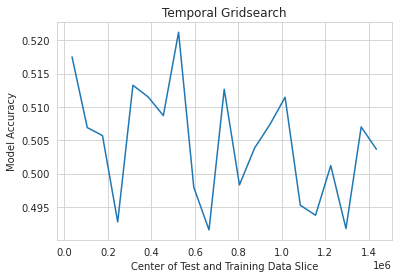

In [ ]:
x_vals = list(range(35000,1500000,70000))

print("Average Accuracy:",sum(accuracies)/len(accuracies))

#Plot Gridsearch Accuracies
plt.plot(x_vals,accuracies)
plt.xlabel("Center of Test and Training Data Slice")
plt.ylabel("Model Accuracy")
plt.title("Temporal Gridsearch")
plt.show()

By training and testing the data in small chunks along the full section of the data, we observe accuracies that range from 48-54% for the same number of principal components and covariance type. 

### Varying Training Data Size
Given that this is a time series, it may be the case that having more data doesn't necessarily mean a more accurate model. In this case, we modify the size of the training dataset while leaving the test size constant in an attempt to identify an optimal training data size.

In [ ]:
#Define a constant test size and a range of training sizes
test_size = 10000
train_sizes = list(range(20000,400000,20000))

#Create an empty list to store accuracies
accuracies = []

for i in train_sizes:
  #Loop through training data sizes, training and testing 2-component GMM models
  gm_train_data, gm_train_labels = X_train[0:i], y_train[0:i]
  gm_test_data, gm_test_labels = X_train[i:i+test_size], y_train[i:i+test_size]

  #Generate 2 GMM models, one for positive data, one for negative
  gm_pos = GaussianMixture(n_components=3,covariance_type='tied',random_state=12345)
  gm_neg = GaussianMixture(n_components=3,covariance_type='tied',random_state=12345)

  #Separate data into positive and negative values
  lab = gm_train_labels.reshape(-1,)
  pos_dat = gm_train_data[lab==1]
  neg_dat = gm_train_data[lab==0]

  #Fit the two GMM models
  gm_pos.fit(pos_dat)
  gm_neg.fit(neg_dat)

  #Calculate log liklihood using both models
  pos_pred = gm_pos.score_samples(gm_test_data)
  neg_pred = gm_neg.score_samples(gm_test_data)

  #Label determination
  pred = (pos_pred > neg_pred) * 1

  #Calculate accuracy
  gmm_acc = round(accuracy_score(gm_test_labels,pred),2)
  print("Accuracy:", gmm_acc)
  accuracies.append(gmm_acc)


Accuracy: 0.5
Accuracy: 0.47
Accuracy: 0.53
Accuracy: 0.52
Accuracy: 0.49
Accuracy: 0.51
Accuracy: 0.51
Accuracy: 0.52
Accuracy: 0.52
Accuracy: 0.49
Accuracy: 0.47
Accuracy: 0.51
Accuracy: 0.5
Accuracy: 0.5
Accuracy: 0.49
Accuracy: 0.49
Accuracy: 0.48
Accuracy: 0.52
Accuracy: 0.51


As training size increases, there doesn't appear to be a predictable relationship between training data size and model accuracy. However, there is a sweet spot of high accuracies in the 60-80k examples range as well as the 120-180K examples range. To increase model speed, we will focus on the 60-80k range.

In [ ]:
plt.plot(train_sizes, accuracies)
plt.title("Train Data Size vs. Model Accuracy")
plt.xlabel("Training Data Size")
plt.ylabel("Model Accuracy")
plt.show()

NameError: ignored

### Principal Component Analysis

In [ ]:
exp_var = []

#Calculate explained variance for 1-98 principal components
k_values = list(range(1,80))
for k in k_values:
    pca = PCA(n_components=k)
    pca.fit(mini_train_data)
    exp_var.append(sum(pca.explained_variance_ratio_))
print("Complete")

Complete


PCA run on the train_data (70,000 rows) shows that 90% of variance in the data can be accounted for in 25 components and 98% of variance in the data can be accounted for in 60 components. Moving forward, we will implement our PCA with 60 principal components.

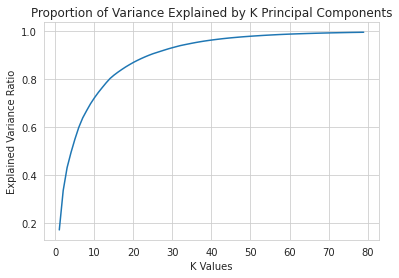

In [ ]:
# Plot explained variance against PCA Component Count
plt.plot(k_values, exp_var)
plt.title("Proportion of Variance Explained by K Principal Components")
plt.xlabel("K Values")
plt.ylabel("Explained Variance Ratio")
plt.show()

### GMM with PCA

When we implement a 25-45 component PCA with GMM, the 5-component model now performs better than the three component. However, this performance isn't better than our most accurate models without PCA, so we will refrain from implementing.

GMM Loop: 2
GMM Loop: 3
GMM Loop: 4
GMM Loop: 5


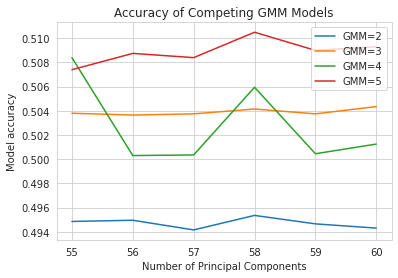

In [ ]:
cov_typ='spherical'



for gmm_n in range(2,6):
    accuracies = []
    for pca_n in range(55,61):
        
        pca = PCA(n_components=pca_n)
        pca_dat = pca.fit_transform(mini_train_data)
        pca_test = pca.transform(test_data)

        #Generate 2 GMM models, one for positive data, one for negative
        gm_pos = GaussianMixture(n_components=gmm_n,covariance_type=cov_typ,random_state=12345)
        gm_neg = GaussianMixture(n_components=gmm_n,covariance_type=cov_typ,random_state=12345)

        #Separate data into positive and negative values
        lab = mini_train_labels.reshape(-1,)
        pos_dat = pca_dat[lab==1]
        neg_dat = pca_dat[lab==0]

        #Fit the two GMM models
        gm_pos.fit(pos_dat)
        gm_neg.fit(neg_dat)

        #Calculate log liklihood using both models
        pos_pred = gm_pos.score_samples(pca_test)
        neg_pred = gm_neg.score_samples(pca_test)

        #Label determination
        pred = (pos_pred > neg_pred) * 1

        #Calculate accuracy
        lab=test_labels.reshape(-1,)
        count_matches = np.sum((pred==lab))
        acc = count_matches/pred.shape[0]
        accuracies.append(acc)

    print("GMM Loop:",gmm_n)
    
    plt.plot(list(range(55,61)),accuracies)
plt.legend(['GMM=2','GMM=3','GMM=4','GMM=5'])
plt.xlabel("Number of Principal Components")
plt.ylabel("Model accuracy")
plt.title("Accuracy of Competing GMM Models")
plt.show()

### Add Model to Horse Race

In [ ]:
gmm_avg_acc = sum(temporal_accuracies)/len(temporal_accuracies)
gmm_avg_util = sum(temporal_utilities)/len(temporal_utilities)

#Add to Horse Race
horse_race['model'].append("GMM Model")
horse_race['accuracy'].append(gmm_avg_acc)
horse_race['utility'].append(gmm_avg_util)

print(horse_race)

{'model': ['GMM Model', 'GMM Model'], 'accuracy': [0.5044380952380954], 'utility': [52.865993698386355]}


### Summary

After implementing and refining a Gaussian Mixture Model, we found the results to be generally too inconsistant and unpredictable to have practical value. While this type of model has shown promise in similar applications in the past, its ability to make reliable, accurate predictions based on this dataset is questionable.

## Supervised Autoencoder Multi Layer Perceptron (MLP)

The Supervised Autoencoder Multi Layer Perceptron (MLP) looks like it performs incredibly well on this particular data set, perhaps too well (80%+ validation accuracy, 3000+ utility).

Based on a few sanity checks, it looks like everything checks out. Both validation and training accuracy improve over 3 epochs. The validation loss performs incredibly well, scoring less than 0.001. This further bolsters the validation accuracy score to be true. We also have an incredibly high utility score that ties with the validation accuracy.

As much as we would want to believe that this model holds the keys to the stock market, we still think that the Supervised Autoencoder Multi Layer Perceptron (MLP) is overfitting to our dataset to some extent. We also would need to spend more time understanding exactly what this model is doing before we feel comfortable presenting this as the "holy grail" of stock market prediction models.

In [ ]:
# train autoencoder for classification with no compression in the bottleneck layer
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot

Epoch 1/10
1000/1000 - 4s - loss: 0.0021 - accuracy: 0.7919 - val_loss: 6.8978e-04 - val_accuracy: 0.8579
Epoch 2/10
1000/1000 - 3s - loss: 5.7248e-04 - accuracy: 0.8364 - val_loss: 5.2652e-04 - val_accuracy: 0.8329
Epoch 3/10
1000/1000 - 3s - loss: 4.8285e-04 - accuracy: 0.8521 - val_loss: 6.7483e-04 - val_accuracy: 0.8405
Epoch 4/10
1000/1000 - 3s - loss: 4.3458e-04 - accuracy: 0.8605 - val_loss: 5.4607e-04 - val_accuracy: 0.8643
Epoch 5/10
1000/1000 - 3s - loss: 4.0851e-04 - accuracy: 0.8637 - val_loss: 4.7762e-04 - val_accuracy: 0.8432
Epoch 6/10
1000/1000 - 3s - loss: 3.8076e-04 - accuracy: 0.8689 - val_loss: 4.4095e-04 - val_accuracy: 0.8938
Epoch 7/10
1000/1000 - 3s - loss: 3.6115e-04 - accuracy: 0.8728 - val_loss: 3.7776e-04 - val_accuracy: 0.8693
Epoch 8/10
1000/1000 - 3s - loss: 3.5378e-04 - accuracy: 0.8708 - val_loss: 5.4731e-04 - val_accuracy: 0.9085
Epoch 9/10
1000/1000 - 3s - loss: 3.4801e-04 - accuracy: 0.8719 - val_loss: 4.2522e-04 - val_accuracy: 0.8674
Epoch 10/10
10

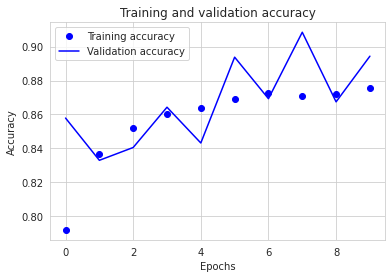

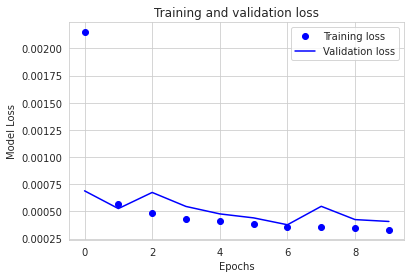

|    | model                                               |   accuracy |   utility |
|---:|:----------------------------------------------------|-----------:|----------:|
|  0 | Supervised Autoencoder Multi Layer Perceptron (MLP) |    0.90848 |   5369.87 |


In [ ]:
# Iniitalize varialbes, define train and test data.
horse_race_mlp = {'model' : [], 'accuracy' : [], 'utility' : []}

X_train_mlp = mini_train_data
y_train_mlp = mini_train_labels
X_test_mlp = dev_data
y_test_mlp = dev_labels

n_inputs = train_data.shape[1]

# Source: https://machinelearningmastery.com/autoencoder-for-classification/
# scale data
t = MinMaxScaler()
t.fit(X_train_mlp)
X_train_mlp = t.transform(X_train_mlp)
X_test_mlp = t.transform(X_test_mlp)
# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

# output layer
#output = Dense(n_inputs, activation='softmax')(d)
output = Dense(n_inputs, activation='sigmoid')(d)

# define autoencoder model
mlp_model = Model(inputs=visible, outputs=output)

# compile autoencoder model
mlp_model.compile(optimizer='adam', loss='mse', metrics='accuracy')

# fit the autoencoder model to reconstruct input
history_mlp = mlp_model.fit(X_train_mlp, X_train_mlp, epochs=10, batch_size=50, verbose=2, validation_data=(X_test_mlp,X_test_mlp))
#history_mlp = mlp_model.fit(X_train_mlp, X_train_mlp, epochs=10, batch_size=3500, verbose=2, validation_data=(X_test_mlp,X_test_mlp))
#history_mlp = mlp_model.fit(X_train_mlp, y_train_mlp, epochs=3, batch_size=50, verbose=2, validation_data=(X_test_mlp,y_test_mlp))

# Source: https://www.datacamp.com/community/tutorials/autoencoder-classifier-python 
print("Accuracy:", history_mlp.history['val_accuracy'])

# Plot accuracy and loss history over epoch iterations
accuracy = history_mlp.history['accuracy']
val_accuracy = history_mlp.history['val_accuracy']
loss = history_mlp.history['loss']
val_loss = history_mlp.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Model Loss')
plt.legend()
plt.show()

# Source: https://www.datacamp.com/community/tutorials/autoencoder-classifier-python
# Unlike the CNN where we have a built-in predict_classes() function, the autoencoder MLP doesn't have a built in function.
# Therefore, we will create it ourselves with the predict() function.
predicted_classes = (mlp_model.predict(dev_data) > 0.5).astype("int32")
predicted_classes = predicted_classes.argmax(axis=-1)
# print(mlp_model.predict(dev_data)[0])
# print(max(mlp_model.predict(dev_data)[0]))
# print(min(mlp_model.predict(dev_data)[0]))
# print(predicted_classes)

# Append to MLP's own horse race table to sanity check.
horse_race_mlp['model'].append("Supervised Autoencoder Multi Layer Perceptron (MLP)")
horse_race_mlp['accuracy'].append(max(history_mlp.history['val_accuracy']))
#print("Predicted Classes Shape:", predicted_classes.shape)
#print("Dev_Dates Shape:", dev_dates.shape)
horse_race_mlp['utility'].append(utility(dev_weights,dev_resps, predicted_classes,dev_dates))
print(tabulate(pd.DataFrame(horse_race_mlp), tablefmt="pipe", headers="keys"))

# Append to main horse race table. 
# horse_race['model'].append("Supervised Autoencoder Multi Layer Perceptron (MLP)")
# horse_race['accuracy'].append(max(history_mlp.history['val_accuracy']))
# horse_race['utility'].append(utility(dev_weights,dev_resps, predicted_classes,dev_dates))
# print(tabulate(pd.DataFrame(horse_race), tablefmt="pipe", headers="keys"))

## Conclusion

We present the end result of [our horse race for all models](https://docs.google.com/spreadsheets/d/1qy7T_1p1P2CzDHFpBR_bkxBhi3OihNT7rPXsa5KtX4k/edit?usp=sharing) - measuring accuracy & utility.

At the end, the 3 models we went the deepest on (LSTM, CNN, GMM) did not perform significantly better than the rest. At the time of running our models, the Elastic Net generated the highest utility score, while the Bernoulli Naive Bayes generated the highest accuracy. 

One silver lining is that the 3 more complex models we focused on generated more consistent results in terms of accuracy vs. the simpler models (the simpler models generated more stochastic results).

Its important to reiterate that in stock market prediction, accuracies in the 50-60%'s is not something to be ashamed of, as you can still make alot of money with a model with 55% accuracy.
This is in stark contrast to some other industries, such as the 80-90%+ accuracy required for facial recognition software, self-driving cars, etc.

#### Model Conclusions

CNN

  - The CNN model performed roughly in-line with other models that we tested. 

  - Even though the model's performance was satisfactory, the variance in both utility score and accuracy given tiny tweaks in the parameters and epochs was higher than we would like to see. Especially in an industry such as finance that already has numerous unforeseen tail risks that can emerge at any time ("black swans"), we would likely prefer to use other models that can generate smaller/minimal variance in both its utility and accuracy scores.

LSTM
  - 
  -

GMM
  - The GMM model initially showed promise but failed to reach a level of accuracy that differentiated it from other model.
  - The GMM utility score is extremely low compared to other models. Future work is required to determine whether this is an error or simply a symptom of the model accuracy being barely over 50%.

#### Areas for Improvement and Future Work

- Implementing exhaustive Grid Search
- Doing more in-depth analysis on the simpler models

In [ ]:
# Appendix: Plotting horse race on matplotlib

# Source: https://cmdlinetips.com/2019/10/how-to-make-a-plot-with-two-different-y-axis-in-python-with-matplotlib/

# # create figure and axis objects with subplots()
# fig,ax = plt.subplots(figsize=(10,4))
# # make a plot
# ax.plot(horse_race['model'], horse_race['accuracy'], color="red", marker="o")
# # set x-axis label
# ax.set_xlabel("Model",fontsize=14)
# # set y-axis label
# ax.set_ylabel("Accuracy",color="red",fontsize=14)

# # twin object for two different y-axis on the sample plot
# ax2=ax.twinx()
# # make a plot with different y-axis using second axis object
# ax2.bar(horse_race['model'], horse_race['utility'],color="blue", alpha = 0.5)
# ax2.set_ylabel("Utility",color="blue",fontsize=14)
# # Prevent x labels from overlapping
# # Source: https://programmersought.com/article/50984561968/
# # Source: https://stackoverflow.com/questions/8384120/equivalent-function-for-xticks-for-an-axessubplot-object
# ax.set_xticklabels(horse_race['model'], rotation=50, fontsize=10)

# plt.show()

# # Save the plot as a jpg file
# fig.savefig('drive/MyDrive/w207-6-spring2021-fintech/horse_race.jpg',
#             format='jpeg',
#             dpi=100,
#             bbox_inches='tight')

# # Export to csv
# df = pd.DataFrame(horse_race) 
# df.to_csv('drive/MyDrive/w207-6-spring2021-fintech/Excel Files/horse_race_to_csv.csv')

## References

1. LSTM:
  * https://colah.github.io/posts/2015-08-Understanding-LSTMs/
  * https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0227222#:~:text=Long%20short%2Dterm%20memory%20(LSTM,helps%20predict%20financial%20time%20series.
  

2. CNN: 
  * https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5
  * https://webcache.googleusercontent.com/search?q=cache:O_aNQyJ29XMJ:
  * https://missinglink.ai/guides/convolutional-neural-networks/python-convolutional-neural-network-creating-cnn-keras-tensorflow-plain-python/+&cd=1&hl=en&ct=clnk&gl=us 
  * https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5
  * https://towardsdatascience.com/build-your-own-convolution-neural-network-in-5-mins-4217c2cf964f
